In [ ]:
# Cell 1: 安裝必要的套件
# 請確保您在可以執行 pip install 的環境中執行此 Notebook
# 如果在 Colab 或類似環境，取消註解下一行並執行
# !pip install -q git+https://github.com/m-bain/whisperX.git transformers torch torchaudio soundfile librosa ipywidgets faster-whisper

print("必要的套件理論上已安裝。如果遇到 'ModuleNotFoundError'，請取消註解並執行上面的 pip install 指令。")

In [7]:
# Cell 2: 匯入套件與設定參數
import os
import glob
import torch
import whisperx # 用於對齊
from transformers import pipeline # 用於載入微調模型
import soundfile as sf # 用於某些情況下讀取音訊
import re # 用於處理檔名

# --- 設定 ---
# 您的微調 Whisper 模型路徑 (Hugging Face Transformers 格式)
FINETUNED_MODEL_PATH = r"./whisper-large-v3-finetuned-custom-with-timestamps"

# 包含音訊檔案的目錄
AUDIO_DIR = r"./dataset/private"

# 輸出檔案名稱
OUTPUT_NO_TIMESTAMPS_FILE = "transcription_no_timestamps.txt"
OUTPUT_WITH_TIMESTAMPS_FILE = "transcription_with_timestamps.txt"

# 選擇運算裝置 (cuda: GPU, cpu: CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"將使用的運算裝置: {DEVICE}")
if DEVICE == "cuda":
    torch.cuda.set_device(0)

# 音訊語言代碼
# 由於音訊主要為英文，少量中文，我們將主要語言設為英文 "en"
# 這將有助於英文部分的對齊，但中文部分的對齊可能不佳或不準確
LANGUAGE_CODE = "en"
print(f"設定主要語言為: {LANGUAGE_CODE} (針對英文優化，中文部分可能對齊不佳)")

# HuggingFace Pipeline 的設定
PIPELINE_CHUNK_LENGTH_S = 30
PIPELINE_BATCH_SIZE = 8

# --- 新增：重複懲罰設定 ---
REPETITION_PENALTY = 1.2  # 建議值在 1.1 ~ 1.5 之間，您可以根據效果調整
NO_REPEAT_NGRAM_SIZE = 3  # 例如設為 3，表示連續 3 個詞的序列不會重複，可設為 0 以禁用

# --- 檢查路徑是否存在 ---
if not os.path.exists(FINETUNED_MODEL_PATH):
    print(f"警告: 模型路徑 '{FINETUNED_MODEL_PATH}' 不存在。請確認路徑是否正確。")
if not os.path.exists(AUDIO_DIR):
    print(f"警告: 音訊目錄 '{AUDIO_DIR}' 不存在。請確認路徑是否正確。")

print("參數設定完成。")

將使用的運算裝置: cuda
設定主要語言為: en (針對英文優化，中文部分可能對齊不佳)
參數設定完成。


In [8]:
# Cell 3: 載入模型
# 1. 載入您微調的 ASR (Automatic Speech Recognition) 模型
#    我們使用 transformers.pipeline 來載入，這樣比較通用
#    `return_timestamps=True` 會讓 pipeline 輸出區段級別的時間戳
print(f"正在載入微調的 ASR 模型從: {FINETUNED_MODEL_PATH}...")
try:
    asr_pipeline = pipeline(
        "automatic-speech-recognition",
        model=FINETUNED_MODEL_PATH,
        torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32, # 在 GPU 上使用 float16 以節省記憶體並加速
        device=DEVICE,
    )
    print("微調的 ASR 模型載入成功。")
except Exception as e:
    print(f"載入微調的 ASR 模型失敗: {e}")
    print("請檢查您的模型路徑和模型是否與 transformers.pipeline 相容。")
    # 如果模型載入失敗，後續程式碼將無法執行，可以考慮在此處拋出錯誤或退出
    asr_pipeline = None

# 2. 載入 WhisperX 的對齊模型
#    這個模型用於將 ASR 的輸出文字與音訊進行精確的詞級別對齊
print(f"正在載入 WhisperX 對齊模型，語言: {LANGUAGE_CODE}...")
try:
    align_model, align_metadata = whisperx.load_align_model(
        language_code=LANGUAGE_CODE,
        device=DEVICE
    )
    print("WhisperX 對齊模型載入成功。")
except Exception as e:
    print(f"載入 WhisperX 對齊模型失敗: {e}")
    align_model = None

正在載入微調的 ASR 模型從: ./whisper-large-v3-finetuned-custom-with-timestamps...


Loading checkpoint shards: 100%|██████████| 2/2 [00:34<00:00, 17.30s/it]
Device set to use cuda


微調的 ASR 模型載入成功。
正在載入 WhisperX 對齊模型，語言: en...
WhisperX 對齊模型載入成功。


In [9]:
# Cell 4: 定義音訊處理和檔案寫入的主要邏輯 (整合備援方案)

def process_audio_files():
    if not asr_pipeline or not align_model:
        print("模型未成功載入，無法處理音訊檔案。")
        return

    supported_extensions = ["*.wav", "*.mp3", "*.flac", "*.m4a", "*.ogg"]
    audio_files = []
    for ext in supported_extensions:
        audio_files.extend(glob.glob(os.path.join(AUDIO_DIR, ext)))

    if not audio_files:
        print(f"在 '{AUDIO_DIR}' 中沒有找到任何支援的音訊檔案。")
        return

    print(f"找到 {len(audio_files)} 個音訊檔案，開始處理...")

    lines_no_timestamps = []
    lines_with_timestamps = []

    for i, audio_path in enumerate(audio_files):
        filename = os.path.basename(audio_path)
        print(f"\n正在處理檔案 {i+1}/{len(audio_files)}: {filename}")

        # 對於每個檔案，定義 ASR 的生成參數，以便在主流程和備援流程中可以共用
        generate_kwargs_config = {
            "language": LANGUAGE_CODE,
            "task": "transcribe",
            "repetition_penalty": REPETITION_PENALTY
        }
        if NO_REPEAT_NGRAM_SIZE > 0:
            generate_kwargs_config["no_repeat_ngram_size"] = NO_REPEAT_NGRAM_SIZE
        
        initial_asr_plain_text = "ASR_TEXT_NOT_GENERATED" # 初始化，用於記錄無時間戳文本

        try:
            # 步驟 1: 初始 ASR (用於獲取 WhisperX 對齊所需的 segments)
            print(f"  進行初始 ASR 轉錄 (語言提示: {LANGUAGE_CODE}, 重複懲罰: {REPETITION_PENALTY}, No-Repeat Ngram: {NO_REPEAT_NGRAM_SIZE})...")
            initial_asr_output = asr_pipeline(
                audio_path,
                chunk_length_s=PIPELINE_CHUNK_LENGTH_S,
                batch_size=PIPELINE_BATCH_SIZE,
                return_timestamps=True, # 獲取區段級別時間戳給 WhisperX
                generate_kwargs=generate_kwargs_config
            )

            if not initial_asr_output or not initial_asr_output.get("text", "").strip():
                print(f"  警告: 初始 ASR 模型未對 '{filename}' 產生有效文字輸出。跳過此檔案。")
                lines_no_timestamps.append(f"{filename}\t\n")
                lines_with_timestamps.append(f"{filename}\t\n")
                continue
            
            initial_asr_plain_text = initial_asr_output["text"].strip() # 獲取初始ASR的純文字

            # 步驟 2: 準備 segments 給 WhisperX
            segments_for_alignment = []
            if "chunks" in initial_asr_output and initial_asr_output["chunks"]:
                for chunk in initial_asr_output["chunks"]:
                    segment_text = chunk["text"].strip()
                    if segment_text and chunk['timestamp'][0] is not None and chunk['timestamp'][1] is not None:
                         segments_for_alignment.append({
                            "text": segment_text,
                            "start": chunk["timestamp"][0],
                            "end": chunk["timestamp"][1]
                        })
                    elif not segment_text and chunk['timestamp'][0] is not None and chunk['timestamp'][1] is not None:
                        print(f"  資訊: 檔案 '{filename}' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: '{chunk['text']}'")

            if not segments_for_alignment:
                 fallback_text_for_segments = initial_asr_plain_text # 使用已獲取的純文字
                 if fallback_text_for_segments:
                     print(f"  警告: 檔案 '{filename}' 未能從 ASR chunks 獲取有效區段。將使用完整文本進行對齊。")
                     try:
                         audio_info = sf.info(audio_path)
                         segments_for_alignment.append({
                             "text": fallback_text_for_segments,
                             "start": 0.0,
                             "end": audio_info.duration
                         })
                     except Exception as sf_exc:
                         print(f"  錯誤: 無法獲取音訊 '{filename}' 的時長: {sf_exc}。無法創建 fallback 區段。")
                 else: # initial_asr_plain_text 也是空的
                     print(f"  警告: 檔案 '{filename}' 初始 ASR 輸出文本為空，無法進行對齊。")
                     lines_no_timestamps.append(f"{filename}\t\n")
                     lines_with_timestamps.append(f"{filename}\t\n")
                     continue

            if not segments_for_alignment:
                print(f"  錯誤: 檔案 '{filename}' 最終沒有準備好任何有效區段用於 WhisperX 對齊。跳過。")
                lines_no_timestamps.append(f"{filename}\t{initial_asr_plain_text}\n") # 記錄初始ASR文本
                lines_with_timestamps.append(f"{filename}\tNO_SEGMENTS_FOR_ALIGNMENT\n")
                continue

            # 步驟 3: WhisperX 對齊
            print(f"  進行 WhisperX 詞級別對齊 (使用 {LANGUAGE_CODE} 對齊模型)...")
            audio_for_align = whisperx.load_audio(audio_path)
            aligned_result = whisperx.align(
                segments_for_alignment, align_model, align_metadata,
                audio_for_align, DEVICE, return_char_alignments=False
            )
            del audio_for_align
            if DEVICE == "cuda": torch.cuda.empty_cache()

            # 步驟 4: 格式化 WhisperX 成功時的輸出
            word_timestamps_parts = []
            if aligned_result and "word_segments" in aligned_result:
                for word_info in aligned_result["word_segments"]:
                    word = word_info.get("word", "").strip()
                    if not word: continue
                    start_time, end_time = word_info.get("start"), word_info.get("end")
                    if start_time is not None and end_time is not None:
                        word_timestamps_parts.append(f"{word}[{start_time:.2f}-{end_time:.2f}]")
                    else:
                        word_timestamps_parts.append(word)
            else:
                # 如果 aligned_result 沒有 word_segments，也視為一種對齊問題，可以觸發備援
                print(f"  警告: WhisperX 對齊後未找到 'word_segments' for '{filename}'。將嘗試備援方案。")
                raise ValueError("WhisperX alignment did not produce word_segments.") # 主動拋出錯誤以進入備援

            formatted_whisperx_words = "".join(word_timestamps_parts)
            if not formatted_whisperx_words.strip() and initial_asr_plain_text:
                 print(f"  注意: 檔案 '{filename}' WhisperX對齊後無詞級時間戳。將在時間戳文件中記錄無時間戳文本。")
                 # formatted_whisperx_words = initial_asr_plain_text # 或保持為空，根據需求

            lines_no_timestamps.append(f"{filename}\t{initial_asr_plain_text}\n")
            lines_with_timestamps.append(f"{filename}\t{formatted_whisperx_words}\n")
            print(f"  檔案 '{filename}' 使用 WhisperX 成功處理。")

        except Exception as e_main: # 主流程 (包含初始ASR或WhisperX對齊) 失敗
            print(f"  檔案 '{filename}' 在主要處理流程中發生錯誤: {e_main}")
            # import traceback # 可取消註解此行以進行深度偵錯
            # traceback.print_exc()
            print(f"  嘗試使用 Whisper 原生詞級時間戳作為備援方案...")

            try:
                # 備援方案: 使用 Whisper 原生詞級時間戳
                fallback_asr_output = asr_pipeline(
                    audio_path,
                    chunk_length_s=PIPELINE_CHUNK_LENGTH_S,
                    batch_size=PIPELINE_BATCH_SIZE,
                    return_timestamps="word", # **明確要求詞級時間戳**
                    generate_kwargs=generate_kwargs_config # 使用相同的生成參數
                )

                if fallback_asr_output and fallback_asr_output.get("chunks"):
                    fallback_plain_text = fallback_asr_output["text"].strip()
                    # 對於無時間戳文件，使用備援ASR的文本
                    lines_no_timestamps.append(f"{filename}\t{fallback_plain_text}\n")

                    word_ts_parts_fallback = []
                    for word_chunk in fallback_asr_output["chunks"]:
                        word = word_chunk["text"].strip() # Whisper原生輸出可能帶空格
                        if word: # 確保詞不為空
                            timestamp = word_chunk["timestamp"] # (start, end)
                            if timestamp and timestamp[0] is not None and timestamp[1] is not None:
                                word_ts_parts_fallback.append(f"{word}[{timestamp[0]:.2f}-{timestamp[1]:.2f}]")
                            else:
                                word_ts_parts_fallback.append(word) # 若無時間戳，只加詞
                    
                    formatted_words_fallback = "".join(word_ts_parts_fallback)
                    lines_with_timestamps.append(f"{filename}\t{formatted_words_fallback}\n")
                    print(f"  檔案 '{filename}' 已使用 Whisper 原生時間戳處理 (備援方案)。")
                
                else: # 備援ASR失敗或未返回有效 chunks
                    print(f"  備援方案 (Whisper 原生時間戳) 處理失敗或未返回有效 chunks for '{filename}'.")
                    # 嘗試使用初始ASR的文本（如果有的話），否則記錄錯誤
                    lines_no_timestamps.append(f"{filename}\t{initial_asr_plain_text if initial_asr_plain_text != 'ASR_TEXT_NOT_GENERATED' else 'ERROR_NO_ASR_TEXT'}\n")
                    lines_with_timestamps.append(f"{filename}\tERROR_PROCESSING_FILE_FALLBACK_FAILED\n")

            except Exception as e_fallback:
                print(f"  執行備援方案 (Whisper 原生時間戳) 時也發生錯誤 for '{filename}': {e_fallback}")
                # import traceback; traceback.print_exc() # 備援方案的深度偵錯
                lines_no_timestamps.append(f"{filename}\t{initial_asr_plain_text if initial_asr_plain_text != 'ASR_TEXT_NOT_GENERATED' else 'ERROR_NO_ASR_TEXT'}\n")
                lines_with_timestamps.append(f"{filename}\tERROR_DURING_FALLBACK_PROCESSING\n")
            
            if DEVICE == "cuda": # 清理GPU緩存
                torch.cuda.empty_cache()

    # ... (寫入檔案部分不變) ...
    print(f"\n所有檔案處理完畢。正在寫入輸出檔案...")
    try:
        with open(OUTPUT_NO_TIMESTAMPS_FILE, "w", encoding="utf-8") as f_no_ts:
            f_no_ts.writelines(lines_no_timestamps)
        print(f"無時間戳的轉錄已儲存到: {OUTPUT_NO_TIMESTAMPS_FILE}")

        with open(OUTPUT_WITH_TIMESTAMPS_FILE, "w", encoding="utf-8") as f_with_ts:
            f_with_ts.writelines(lines_with_timestamps)
        print(f"帶時間戳的轉錄已儲存到: {OUTPUT_WITH_TIMESTAMPS_FILE}")
    except Exception as e:
        print(f"寫入輸出檔案時發生錯誤: {e}")

# print("\n--- Cell 4 定義完畢 ---")
# print("提醒：執行前請確保 Cell 2 和 Cell 3 已正確執行。")
process_audio_files() # 您準備好後可以取消註解這行來執行

找到 710 個音訊檔案，開始處理...

正在處理檔案 1/710: 60014.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50360]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60014.wav' 使用 WhisperX 成功處理。

正在處理檔案 2/710: 60015.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60015.wav' 使用 WhisperX 成功處理。

正在處理檔案 3/710: 60018.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60018.wav' 使用 WhisperX 成功處理。

正在處理檔案 4/710: 60022.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60022.wav' 使用 WhisperX 成功處理。

正在處理檔案 5/710: 60049.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60049.wav' 使用 WhisperX 成功處理。

正在處理檔案 6/710: 60079.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60079.wav' 使用 WhisperX 成功處理。

正在處理檔案 7/710: 60084.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60084.wav' 使用 WhisperX 成功處理。

正在處理檔案 8/710: 60102.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60102.wav' 使用 WhisperX 成功處理。

正在處理檔案 9/710: 60147.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60147.wav' 使用 WhisperX 成功處理。

正在處理檔案 10/710: 60167.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  檔案 '60167.wav' 使用 WhisperX 成功處理。

正在處理檔案 11/710: 60180.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60180.wav' 使用 WhisperX 成功處理。

正在處理檔案 12/710: 60184.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60184.wav' 使用 WhisperX 成功處理。

正在處理檔案 13/710: 60197.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60197.wav' 使用 WhisperX 成功處理。

正在處理檔案 14/710: 60226.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60226.wav' 使用 WhisperX 成功處理。

正在處理檔案 15/710: 60239.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60239.wav' 使用 WhisperX 成功處理。

正在處理檔案 16/710: 60243.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60243.wav' 使用 WhisperX 成功處理。

正在處理檔案 17/710: 60245.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60245.wav' 使用 WhisperX 成功處理。

正在處理檔案 18/710: 60253.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60253.wav' 使用 WhisperX 成功處理。

正在處理檔案 19/710: 60267.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60267.wav' 使用 WhisperX 成功處理。

正在處理檔案 20/710: 60275.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60275.wav' 使用 WhisperX 成功處理。

正在處理檔案 21/710: 60286.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60286.wav' 使用 WhisperX 成功處理。

正在處理檔案 22/710: 60290.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60290.wav' 使用 WhisperX 成功處理。

正在處理檔案 23/710: 60330.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60330.wav' 使用 WhisperX 成功處理。

正在處理檔案 24/710: 60349.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '60349.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60349.wav' 使用 WhisperX 成功處理。

正在處理檔案 25/710: 60362.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60362.wav' 使用 WhisperX 成功處理。

正在處理檔案 26/710: 60365.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60365.wav' 使用 WhisperX 成功處理。

正在處理檔案 27/710: 60373.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60373.wav' 使用 WhisperX 成功處理。

正在處理檔案 28/710: 60376.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60376.wav' 使用 WhisperX 成功處理。

正在處理檔案 29/710: 60380.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60380.wav' 使用 WhisperX 成功處理。

正在處理檔案 30/710: 60387.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60387.wav' 使用 WhisperX 成功處理。

正在處理檔案 31/710: 60394.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '60394.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60394.wav' 使用 WhisperX 成功處理。

正在處理檔案 32/710: 60420.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60420.wav' 使用 WhisperX 成功處理。

正在處理檔案 33/710: 60466.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60466.wav' 使用 WhisperX 成功處理。

正在處理檔案 34/710: 60500.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60500.wav' 使用 WhisperX 成功處理。

正在處理檔案 35/710: 60514.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60514.wav' 使用 WhisperX 成功處理。

正在處理檔案 36/710: 60533.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60533.wav' 使用 WhisperX 成功處理。

正在處理檔案 37/710: 60535.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60535.wav' 使用 WhisperX 成功處理。

正在處理檔案 38/710: 60559.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60559.wav' 使用 WhisperX 成功處理。

正在處理檔案 39/710: 60574.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60574.wav' 使用 WhisperX 成功處理。

正在處理檔案 40/710: 60581.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60581.wav' 使用 WhisperX 成功處理。

正在處理檔案 41/710: 60598.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60598.wav' 使用 WhisperX 成功處理。

正在處理檔案 42/710: 60617.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60617.wav' 使用 WhisperX 成功處理。

正在處理檔案 43/710: 60626.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60626.wav' 使用 WhisperX 成功處理。

正在處理檔案 44/710: 60633.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60633.wav' 使用 WhisperX 成功處理。

正在處理檔案 45/710: 60697.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60697.wav' 使用 WhisperX 成功處理。

正在處理檔案 46/710: 60699.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60699.wav' 使用 WhisperX 成功處理。

正在處理檔案 47/710: 60703.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60703.wav' 使用 WhisperX 成功處理。

正在處理檔案 48/710: 60730.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60730.wav' 使用 WhisperX 成功處理。

正在處理檔案 49/710: 60732.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60732.wav' 使用 WhisperX 成功處理。

正在處理檔案 50/710: 60740.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60740.wav' 使用 WhisperX 成功處理。

正在處理檔案 51/710: 60741.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60741.wav' 使用 WhisperX 成功處理。

正在處理檔案 52/710: 60769.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60769.wav' 使用 WhisperX 成功處理。

正在處理檔案 53/710: 60779.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60779.wav' 使用 WhisperX 成功處理。

正在處理檔案 54/710: 60786.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60786.wav' 使用 WhisperX 成功處理。

正在處理檔案 55/710: 60791.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60791.wav' 使用 WhisperX 成功處理。

正在處理檔案 56/710: 60802.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60802.wav' 使用 WhisperX 成功處理。

正在處理檔案 57/710: 60814.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60814.wav' 使用 WhisperX 成功處理。

正在處理檔案 58/710: 60830.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60830.wav' 使用 WhisperX 成功處理。

正在處理檔案 59/710: 60832.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60832.wav' 使用 WhisperX 成功處理。

正在處理檔案 60/710: 60884.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60884.wav' 使用 WhisperX 成功處理。

正在處理檔案 61/710: 60905.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60905.wav' 使用 WhisperX 成功處理。

正在處理檔案 62/710: 60914.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60914.wav' 使用 WhisperX 成功處理。

正在處理檔案 63/710: 60930.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60930.wav' 使用 WhisperX 成功處理。

正在處理檔案 64/710: 60992.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60992.wav' 使用 WhisperX 成功處理。

正在處理檔案 65/710: 60997.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60997.wav' 使用 WhisperX 成功處理。

正在處理檔案 66/710: 61050.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61050.wav' 使用 WhisperX 成功處理。

正在處理檔案 67/710: 61145.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61145.wav' 使用 WhisperX 成功處理。

正在處理檔案 68/710: 61175.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  資訊: 檔案 '61175.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
Failed to align segment ("were prepared across three blocks for detailed examination. This report will be available on our website."): backtrack failed, resorting to original...
  檔案 '61175.wav' 使用 WhisperX 成功處理。

正在處理檔案 69/710: 61176.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61176.wav' 使用 WhisperX 成功處理。

正在處理檔案 70/710: 61211.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '61211.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61211.wav' 使用 WhisperX 成功處理。

正在處理檔案 71/710: 61215.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61215.wav' 使用 WhisperX 成功處理。

正在處理檔案 72/710: 61222.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61222.wav' 使用 WhisperX 成功處理。

正在處理檔案 73/710: 61263.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61263.wav' 使用 WhisperX 成功處理。

正在處理檔案 74/710: 61267.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61267.wav' 使用 WhisperX 成功處理。

正在處理檔案 75/710: 61280.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '61280.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61280.wav' 使用 WhisperX 成功處理。

正在處理檔案 76/710: 61316.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61316.wav' 使用 WhisperX 成功處理。

正在處理檔案 77/710: 61332.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61332.wav' 使用 WhisperX 成功處理。

正在處理檔案 78/710: 61338.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61338.wav' 使用 WhisperX 成功處理。

正在處理檔案 79/710: 61343.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61343.wav' 使用 WhisperX 成功處理。

正在處理檔案 80/710: 61379.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61379.wav' 使用 WhisperX 成功處理。

正在處理檔案 81/710: 61397.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61397.wav' 使用 WhisperX 成功處理。

正在處理檔案 82/710: 61402.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61402.wav' 使用 WhisperX 成功處理。

正在處理檔案 83/710: 61438.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61438.wav' 使用 WhisperX 成功處理。

正在處理檔案 84/710: 61494.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61494.wav' 使用 WhisperX 成功處理。

正在處理檔案 85/710: 61506.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61506.wav' 使用 WhisperX 成功處理。

正在處理檔案 86/710: 61528.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61528.wav' 使用 WhisperX 成功處理。

正在處理檔案 87/710: 61540.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61540.wav' 使用 WhisperX 成功處理。

正在處理檔案 88/710: 61585.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61585.wav' 使用 WhisperX 成功處理。

正在處理檔案 89/710: 61595.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61595.wav' 使用 WhisperX 成功處理。

正在處理檔案 90/710: 61611.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61611.wav' 使用 WhisperX 成功處理。

正在處理檔案 91/710: 61622.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61622.wav' 使用 WhisperX 成功處理。

正在處理檔案 92/710: 61627.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61627.wav' 使用 WhisperX 成功處理。

正在處理檔案 93/710: 61664.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61664.wav' 使用 WhisperX 成功處理。

正在處理檔案 94/710: 61684.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61684.wav' 使用 WhisperX 成功處理。

正在處理檔案 95/710: 61695.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61695.wav' 使用 WhisperX 成功處理。

正在處理檔案 96/710: 61702.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  資訊: 檔案 '61702.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61702.wav' 使用 WhisperX 成功處理。

正在處理檔案 97/710: 61710.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61710.wav' 使用 WhisperX 成功處理。

正在處理檔案 98/710: 61742.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61742.wav' 使用 WhisperX 成功處理。

正在處理檔案 99/710: 61791.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61791.wav' 使用 WhisperX 成功處理。

正在處理檔案 100/710: 61822.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61822.wav' 使用 WhisperX 成功處理。

正在處理檔案 101/710: 61844.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61844.wav' 使用 WhisperX 成功處理。

正在處理檔案 102/710: 61865.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61865.wav' 使用 WhisperX 成功處理。

正在處理檔案 103/710: 61883.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61883.wav' 使用 WhisperX 成功處理。

正在處理檔案 104/710: 61891.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61891.wav' 使用 WhisperX 成功處理。

正在處理檔案 105/710: 61898.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61898.wav' 使用 WhisperX 成功處理。

正在處理檔案 106/710: 61905.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61905.wav' 使用 WhisperX 成功處理。

正在處理檔案 107/710: 61924.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61924.wav' 使用 WhisperX 成功處理。

正在處理檔案 108/710: 61930.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61930.wav' 使用 WhisperX 成功處理。

正在處理檔案 109/710: 61938.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61938.wav' 使用 WhisperX 成功處理。

正在處理檔案 110/710: 61956.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '61956.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61956.wav' 使用 WhisperX 成功處理。

正在處理檔案 111/710: 61977.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61977.wav' 使用 WhisperX 成功處理。

正在處理檔案 112/710: 61987.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61987.wav' 使用 WhisperX 成功處理。

正在處理檔案 113/710: 61989.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61989.wav' 使用 WhisperX 成功處理。

正在處理檔案 114/710: 61995.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '61995.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61995.wav' 使用 WhisperX 成功處理。

正在處理檔案 115/710: 62001.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62001.wav' 使用 WhisperX 成功處理。

正在處理檔案 116/710: 62002.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62002.wav' 使用 WhisperX 成功處理。

正在處理檔案 117/710: 62023.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62023.wav' 使用 WhisperX 成功處理。

正在處理檔案 118/710: 62071.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62071.wav' 使用 WhisperX 成功處理。

正在處理檔案 119/710: 62079.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62079.wav' 使用 WhisperX 成功處理。

正在處理檔案 120/710: 62097.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62097.wav' 使用 WhisperX 成功處理。

正在處理檔案 121/710: 62110.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62110.wav' 使用 WhisperX 成功處理。

正在處理檔案 122/710: 62129.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62129.wav' 使用 WhisperX 成功處理。

正在處理檔案 123/710: 62143.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62143.wav' 使用 WhisperX 成功處理。

正在處理檔案 124/710: 62168.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62168.wav' 使用 WhisperX 成功處理。

正在處理檔案 125/710: 62173.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62173.wav' 使用 WhisperX 成功處理。

正在處理檔案 126/710: 62198.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62198.wav' 使用 WhisperX 成功處理。

正在處理檔案 127/710: 62208.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  資訊: 檔案 '62208.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62208.wav' 使用 WhisperX 成功處理。

正在處理檔案 128/710: 62211.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62211.wav' 使用 WhisperX 成功處理。

正在處理檔案 129/710: 62221.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62221.wav' 使用 WhisperX 成功處理。

正在處理檔案 130/710: 62224.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62224.wav' 使用 WhisperX 成功處理。

正在處理檔案 131/710: 62262.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62262.wav' 使用 WhisperX 成功處理。

正在處理檔案 132/710: 62274.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '62274.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62274.wav' 使用 WhisperX 成功處理。

正在處理檔案 133/710: 62357.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62357.wav' 使用 WhisperX 成功處理。

正在處理檔案 134/710: 62362.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62362.wav' 使用 WhisperX 成功處理。

正在處理檔案 135/710: 62378.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '62378.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62378.wav' 使用 WhisperX 成功處理。

正在處理檔案 136/710: 62398.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62398.wav' 使用 WhisperX 成功處理。

正在處理檔案 137/710: 62403.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62403.wav' 使用 WhisperX 成功處理。

正在處理檔案 138/710: 62444.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62444.wav' 使用 WhisperX 成功處理。

正在處理檔案 139/710: 62445.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62445.wav' 使用 WhisperX 成功處理。

正在處理檔案 140/710: 62457.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62457.wav' 使用 WhisperX 成功處理。

正在處理檔案 141/710: 62479.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62479.wav' 使用 WhisperX 成功處理。

正在處理檔案 142/710: 62480.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62480.wav' 使用 WhisperX 成功處理。

正在處理檔案 143/710: 62498.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62498.wav' 使用 WhisperX 成功處理。

正在處理檔案 144/710: 62505.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62505.wav' 使用 WhisperX 成功處理。

正在處理檔案 145/710: 62511.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62511.wav' 使用 WhisperX 成功處理。

正在處理檔案 146/710: 62513.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62513.wav' 使用 WhisperX 成功處理。

正在處理檔案 147/710: 62546.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62546.wav' 使用 WhisperX 成功處理。

正在處理檔案 148/710: 62548.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62548.wav' 使用 WhisperX 成功處理。

正在處理檔案 149/710: 62572.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62572.wav' 使用 WhisperX 成功處理。

正在處理檔案 150/710: 62578.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62578.wav' 使用 WhisperX 成功處理。

正在處理檔案 151/710: 62579.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62579.wav' 使用 WhisperX 成功處理。

正在處理檔案 152/710: 62595.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62595.wav' 使用 WhisperX 成功處理。

正在處理檔案 153/710: 62612.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62612.wav' 使用 WhisperX 成功處理。

正在處理檔案 154/710: 62616.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62616.wav' 使用 WhisperX 成功處理。

正在處理檔案 155/710: 62625.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62625.wav' 使用 WhisperX 成功處理。

正在處理檔案 156/710: 62639.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62639.wav' 使用 WhisperX 成功處理。

正在處理檔案 157/710: 62667.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62667.wav' 使用 WhisperX 成功處理。

正在處理檔案 158/710: 62697.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62697.wav' 使用 WhisperX 成功處理。

正在處理檔案 159/710: 62700.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62700.wav' 使用 WhisperX 成功處理。

正在處理檔案 160/710: 62718.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62718.wav' 使用 WhisperX 成功處理。

正在處理檔案 161/710: 62773.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62773.wav' 使用 WhisperX 成功處理。

正在處理檔案 162/710: 62774.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62774.wav' 使用 WhisperX 成功處理。

正在處理檔案 163/710: 62808.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62808.wav' 使用 WhisperX 成功處理。

正在處理檔案 164/710: 62834.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62834.wav' 使用 WhisperX 成功處理。

正在處理檔案 165/710: 62836.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62836.wav' 使用 WhisperX 成功處理。

正在處理檔案 166/710: 62877.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62877.wav' 使用 WhisperX 成功處理。

正在處理檔案 167/710: 62900.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62900.wav' 使用 WhisperX 成功處理。

正在處理檔案 168/710: 62905.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62905.wav' 使用 WhisperX 成功處理。

正在處理檔案 169/710: 62917.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62917.wav' 使用 WhisperX 成功處理。

正在處理檔案 170/710: 62931.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62931.wav' 使用 WhisperX 成功處理。

正在處理檔案 171/710: 62940.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62940.wav' 使用 WhisperX 成功處理。

正在處理檔案 172/710: 62951.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62951.wav' 使用 WhisperX 成功處理。

正在處理檔案 173/710: 62959.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62959.wav' 使用 WhisperX 成功處理。

正在處理檔案 174/710: 62993.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62993.wav' 使用 WhisperX 成功處理。

正在處理檔案 175/710: 62998.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62998.wav' 使用 WhisperX 成功處理。

正在處理檔案 176/710: 63034.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63034.wav' 使用 WhisperX 成功處理。

正在處理檔案 177/710: 63044.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63044.wav' 使用 WhisperX 成功處理。

正在處理檔案 178/710: 63057.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63057.wav' 使用 WhisperX 成功處理。

正在處理檔案 179/710: 63062.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63062.wav' 使用 WhisperX 成功處理。

正在處理檔案 180/710: 63075.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63075.wav' 使用 WhisperX 成功處理。

正在處理檔案 181/710: 63082.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63082.wav' 使用 WhisperX 成功處理。

正在處理檔案 182/710: 63108.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63108.wav' 使用 WhisperX 成功處理。

正在處理檔案 183/710: 63123.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63123.wav' 使用 WhisperX 成功處理。

正在處理檔案 184/710: 63149.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63149.wav' 使用 WhisperX 成功處理。

正在處理檔案 185/710: 63167.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63167.wav' 使用 WhisperX 成功處理。

正在處理檔案 186/710: 63175.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63175.wav' 使用 WhisperX 成功處理。

正在處理檔案 187/710: 63182.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63182.wav' 使用 WhisperX 成功處理。

正在處理檔案 188/710: 63197.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63197.wav' 使用 WhisperX 成功處理。

正在處理檔案 189/710: 63225.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63225.wav' 使用 WhisperX 成功處理。

正在處理檔案 190/710: 63240.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63240.wav' 使用 WhisperX 成功處理。

正在處理檔案 191/710: 63256.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63256.wav' 使用 WhisperX 成功處理。

正在處理檔案 192/710: 63268.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63268.wav' 使用 WhisperX 成功處理。

正在處理檔案 193/710: 63301.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63301.wav' 使用 WhisperX 成功處理。

正在處理檔案 194/710: 63312.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63312.wav' 使用 WhisperX 成功處理。

正在處理檔案 195/710: 63313.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63313.wav' 使用 WhisperX 成功處理。

正在處理檔案 196/710: 63323.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63323.wav' 使用 WhisperX 成功處理。

正在處理檔案 197/710: 63330.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63330.wav' 使用 WhisperX 成功處理。

正在處理檔案 198/710: 63348.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63348.wav' 使用 WhisperX 成功處理。

正在處理檔案 199/710: 63356.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63356.wav' 使用 WhisperX 成功處理。

正在處理檔案 200/710: 63365.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63365.wav' 使用 WhisperX 成功處理。

正在處理檔案 201/710: 63378.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63378.wav' 使用 WhisperX 成功處理。

正在處理檔案 202/710: 63387.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63387.wav' 使用 WhisperX 成功處理。

正在處理檔案 203/710: 63389.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63389.wav' 使用 WhisperX 成功處理。

正在處理檔案 204/710: 63406.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63406.wav' 使用 WhisperX 成功處理。

正在處理檔案 205/710: 63430.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63430.wav' 使用 WhisperX 成功處理。

正在處理檔案 206/710: 63436.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63436.wav' 使用 WhisperX 成功處理。

正在處理檔案 207/710: 63447.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63447.wav' 使用 WhisperX 成功處理。

正在處理檔案 208/710: 63450.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63450.wav' 使用 WhisperX 成功處理。

正在處理檔案 209/710: 63464.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63464.wav' 使用 WhisperX 成功處理。

正在處理檔案 210/710: 63500.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63500.wav' 使用 WhisperX 成功處理。

正在處理檔案 211/710: 63553.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63553.wav' 使用 WhisperX 成功處理。

正在處理檔案 212/710: 63554.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63554.wav' 使用 WhisperX 成功處理。

正在處理檔案 213/710: 63569.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '63569.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63569.wav' 使用 WhisperX 成功處理。

正在處理檔案 214/710: 63585.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63585.wav' 使用 WhisperX 成功處理。

正在處理檔案 215/710: 63597.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  資訊: 檔案 '63597.wav' 的一個 ASR chunk 文本 strip 後為空，已被忽略。原始chunk文本: ''
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63597.wav' 使用 WhisperX 成功處理。

正在處理檔案 216/710: 63601.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63601.wav' 使用 WhisperX 成功處理。

正在處理檔案 217/710: 63619.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63619.wav' 使用 WhisperX 成功處理。

正在處理檔案 218/710: 63624.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63624.wav' 使用 WhisperX 成功處理。

正在處理檔案 219/710: 63628.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63628.wav' 使用 WhisperX 成功處理。

正在處理檔案 220/710: 63634.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63634.wav' 使用 WhisperX 成功處理。

正在處理檔案 221/710: 63641.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63641.wav' 使用 WhisperX 成功處理。

正在處理檔案 222/710: 63673.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63673.wav' 使用 WhisperX 成功處理。

正在處理檔案 223/710: 63689.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63689.wav' 使用 WhisperX 成功處理。

正在處理檔案 224/710: 63704.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63704.wav' 使用 WhisperX 成功處理。

正在處理檔案 225/710: 63726.wav
  進行初始 ASR 轉錄 (語言提示: en, 重複懲罰: 1.2, No-Repeat Ngram: 3)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Cell 5: (可選) 顯示部分輸出結果以供檢查
# 此儲存格用於在 Notebook 中直接查看一小部分生成的內容，方便快速驗證。

def display_sample_output(file_path, num_lines=5):
    if not os.path.exists(file_path):
        print(f"檔案 '{file_path}' 不存在。")
        return
    print(f"\n--- {file_path} 的前 {num_lines} 行範例 ---")
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            for i, line in enumerate(f):
                if i < num_lines:
                    print(line.strip())
                else:
                    break
    except Exception as e:
        print(f"讀取檔案 '{file_path}' 時發生錯誤: {e}")

# 顯示無時間戳檔案的範例
display_sample_output(OUTPUT_NO_TIMESTAMPS_FILE)

# 顯示帶時間戳檔案的範例
display_sample_output(OUTPUT_WITH_TIMESTAMPS_FILE)

原生Whisper-large-v3

In [19]:
# --- 載入 WhisperX 的對齊模型 (為中、英文分別載入) ---

# 載入英文對齊模型
print("正在載入英文 (en) WhisperX 對齊模型...")
align_model_en, align_metadata_en = None, None
try:
    align_model_en, align_metadata_en = whisperx.load_align_model(
        language_code="en",
        device=DEVICE
    )
    print("英文對齊模型載入成功。")
except Exception as e:
    print(f"載入英文對齊模型失敗: {e}")

# 載入中文對齊模型
# 注意：舊版 WhisperX 可能不直接支援 'zh'。如果 'zh' 失敗，請嘗試使用 'ja' (日文)，因為它的字符集有重疊，效果通常可用。
print("\n正在載入中文 (zh) WhisperX 對齊模型...")
align_model_zh, align_metadata_zh = None, None
try:
    align_model_zh, align_metadata_zh = whisperx.load_align_model(
        language_code="zh",
        device=DEVICE
    )
    print("中文對齊模型載入成功。")
except Exception as e:
    print(f"載入中文對齊模型失敗: {e}")
    print("提示：如果 'zh' 模型載入失敗，可以嘗試 'ja' 模型作為替代，因其字符集相容性較好。")

正在載入英文 (en) WhisperX 對齊模型...
英文對齊模型載入成功。

正在載入中文 (zh) WhisperX 對齊模型...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


中文對齊模型載入成功。


In [20]:
# Cell 6: 使用原始 Whisper-large-v3 模型進行處理 (已修改為動態選擇對齊模型)

import os
import glob
import torch
import whisperx
import soundfile as sf
from transformers import pipeline

print("--- Cell 6: 開始設定使用 OpenAI Whisper-large-v3 原始模型 ---")

# --- 1. 設定新模型的名稱和新的輸出檔案路徑 (這部分不變) ---
ORIGINAL_MODEL_NAME = "openai/whisper-large-v3"
OUTPUT_NO_TIMESTAMPS_FILE_ORIGINAL = "transcription_no_timestamps_original_model.txt"
OUTPUT_WITH_TIMESTAMPS_FILE_ORIGINAL = "transcription_with_timestamps_original_model.txt"

print(f"將使用的原始模型: {ORIGINAL_MODEL_NAME}")
print(f"無時間戳輸出檔案 (原始模型): {OUTPUT_NO_TIMESTAMPS_FILE_ORIGINAL}")
print(f"帶時間戳輸出檔案 (原始模型): {OUTPUT_WITH_TIMESTAMPS_FILE_ORIGINAL}")

# --- 2. 載入原始的 ASR (Automatic Speech Recognition) 模型 (這部分不變) ---
print(f"\n正在載入原始 ASR 模型: {ORIGINAL_MODEL_NAME}...")
original_asr_pipeline = None
try:
    original_asr_pipeline = pipeline(
        "automatic-speech-recognition",
        model=ORIGINAL_MODEL_NAME,
        torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
        device=DEVICE,
    )
    print(f"原始 ASR 模型 '{ORIGINAL_MODEL_NAME}' 載入成功。")
except Exception as e:
    print(f"載入原始 ASR 模型 '{ORIGINAL_MODEL_NAME}' 失敗: {e}")
    print("請檢查網路連線或模型名稱是否正確。如果此模型未載入，後續處理將無法執行。")


# --- 3. 定義使用原始模型的音訊處理函數 (完整修改版) ---
def process_audio_files_original_model():
    # 【修改】: 檢查 ASR 模型和兩種對齊模型是否都已成功載入
    if not original_asr_pipeline:
        print(f"原始 ASR 模型 ({ORIGINAL_MODEL_NAME}) 未成功載入，無法處理音訊檔案。")
        return
    # 假設 align_model_en 和 align_model_zh 在全域範圍內可用
    if 'align_model_en' not in globals() or 'align_model_zh' not in globals() or not align_model_en or not align_model_zh:
        print(f"英文或中文的 WhisperX 對齊模型未能成功載入，無法處理音訊檔案。")
        print("請確保您已在前一個 Cell 成功載入 align_model_en 和 align_model_zh。")
        return

    supported_extensions = ["*.wav", "*.mp3", "*.flac", "*.m4a", "*.ogg"]
    audio_files = []
    for ext in supported_extensions:
        audio_files.extend(glob.glob(os.path.join(AUDIO_DIR, ext)))

    if not audio_files:
        print(f"在 '{AUDIO_DIR}' 中沒有找到任何支援的音訊檔案。")
        return

    print(f"\n找到 {len(audio_files)} 個音訊檔案，開始使用 '{ORIGINAL_MODEL_NAME}' 進行處理...")

    lines_no_timestamps_orig = []
    lines_with_timestamps_orig = []

    for i, audio_path in enumerate(audio_files):
        filename = os.path.basename(audio_path)
        print(f"\n正在處理檔案 {i+1}/{len(audio_files)} (原始模型): {filename}")

        # 【修改】: 根據檔名規則決定語言，並選擇對應的對齊模型
        current_language_code = None
        current_align_model = None
        current_align_metadata = None
        
        try:
            file_number_str = os.path.splitext(filename)[0]
            file_number = int(file_number_str)
            
            if file_number < 80000:
                current_language_code = "en"
                current_align_model = align_model_en
                current_align_metadata = align_metadata_en
            else:
                current_language_code = "zh"
                current_align_model = align_model_zh
                current_align_metadata = align_metadata_zh
            
            print(f"  根據檔名規則，判定語言為: '{current_language_code}'，將使用對應的對齊模型。")

        except ValueError:
            print(f"  警告: 檔名 '{filename}' 不符合純數字格式，無法判斷語言。將跳過此檔案。")
            continue

        # 【修改】: 將 ASR 參數設定移至迴圈內，使用動態決定的語言代碼
        generate_kwargs_config_orig = {
            "language": current_language_code,
            "task": "transcribe",
            "repetition_penalty": REPETITION_PENALTY
        }
        if NO_REPEAT_NGRAM_SIZE > 0:
            generate_kwargs_config_orig["no_repeat_ngram_size"] = NO_REPEAT_NGRAM_SIZE
        
        initial_asr_plain_text_orig = "ASR_TEXT_NOT_GENERATED_ORIG_MODEL"

        try:
            # 步驟 1: 初始 ASR (使用動態語言提示)
            print(f"  進行初始 ASR 轉錄 (原始模型, 語言提示: {current_language_code})...")
            initial_asr_output_orig = original_asr_pipeline(
                audio_path,
                chunk_length_s=PIPELINE_CHUNK_LENGTH_S,
                batch_size=PIPELINE_BATCH_SIZE,
                return_timestamps=True,
                generate_kwargs=generate_kwargs_config_orig
            )

            if not initial_asr_output_orig or not initial_asr_output_orig.get("text", "").strip():
                print(f"  警告: 原始 ASR 模型未對 '{filename}' 產生有效文字輸出。跳過。")
                lines_no_timestamps_orig.append(f"{filename}\t\n")
                lines_with_timestamps_orig.append(f"{filename}\t\n")
                continue
            
            initial_asr_plain_text_orig = initial_asr_output_orig["text"].strip()

            # 步驟 2: 準備 segments 給 WhisperX (邏輯不變)
            segments_for_alignment_orig = []
            if "chunks" in initial_asr_output_orig and initial_asr_output_orig["chunks"]:
                for chunk in initial_asr_output_orig["chunks"]:
                    segment_text = chunk["text"].strip()
                    if segment_text and chunk['timestamp'][0] is not None and chunk['timestamp'][1] is not None:
                         segments_for_alignment_orig.append({
                            "text": segment_text, "start": chunk["timestamp"][0], "end": chunk["timestamp"][1]
                        })
            
            if not segments_for_alignment_orig and initial_asr_plain_text_orig:
                print(f"  警告: '{filename}' 未從 chunks 獲取有效區段。將用完整文本對齊。")
                try:
                    audio_info = sf.info(audio_path)
                    segments_for_alignment_orig.append({
                        "text": initial_asr_plain_text_orig, "start": 0.0, "end": audio_info.duration
                    })
                except Exception as sf_exc:
                    print(f"  錯誤: 無法獲取 '{filename}' 時長: {sf_exc}。")
                    continue
            
            if not segments_for_alignment_orig:
                 print(f"  錯誤: '{filename}' 無有效區段用於 WhisperX 對齊。跳過。")
                 lines_no_timestamps_orig.append(f"{filename}\t{initial_asr_plain_text_orig}\n")
                 lines_with_timestamps_orig.append(f"{filename}\tNO_SEGMENTS_FOR_ALIGNMENT_ORIG_MODEL\n")
                 continue

            # 步驟 3: WhisperX 對齊
            print(f"  進行 WhisperX 詞級別對齊 (使用 {current_language_code} 對齊模型)...")
            audio_for_align = whisperx.load_audio(audio_path)
            
            # 【修改】: 傳入當前迴圈所選擇的對齊模型和元數據
            aligned_result_orig = whisperx.align(
                segments_for_alignment_orig, 
                current_align_model,       # 使用選擇的模型
                current_align_metadata,    # 使用選擇的元數據
                audio_for_align, 
                DEVICE, 
                return_char_alignments=False
            )
            del audio_for_align
            if DEVICE == "cuda": torch.cuda.empty_cache()

            # 步驟 4: 格式化 WhisperX 成功時的輸出 (邏輯不變)
            word_timestamps_parts_orig = []
            if aligned_result_orig and "word_segments" in aligned_result_orig:
                for word_info in aligned_result_orig["word_segments"]:
                    word = word_info.get("word", "").strip()
                    if not word: continue
                    start_time, end_time = word_info.get("start"), word_info.get("end")
                    if start_time is not None and end_time is not None:
                        word_timestamps_parts_orig.append(f"{word}[{start_time:.2f}-{end_time:.2f}]")
                    else:
                        word_timestamps_parts_orig.append(word)
            else:
                print(f"  警告: WhisperX 對齊後未找到 'word_segments' for '{filename}'。將嘗試備援。")
                raise ValueError("WhisperX alignment (original model ASR) did not produce word_segments.")

            formatted_whisperx_words_orig = "".join(word_timestamps_parts_orig)
            lines_no_timestamps_orig.append(f"{filename}\t{initial_asr_plain_text_orig}\n")
            lines_with_timestamps_orig.append(f"{filename}\t{formatted_whisperx_words_orig}\n")
            print(f"  檔案 '{filename}' (原始模型) 使用 WhisperX 成功處理。")

        except Exception as e_main_orig:
            print(f"  檔案 '{filename}' (原始模型) 在主要流程中發生錯誤: {e_main_orig}")
            print(f"  嘗試使用原始 Whisper 模型 ({ORIGINAL_MODEL_NAME}) 的原生詞級時間戳作為備援...")

            try:
                # 備援方案也會使用上面已經設定好的、帶有正確語言的 generate_kwargs_config_orig
                fallback_asr_output_orig = original_asr_pipeline(
                    audio_path,
                    chunk_length_s=PIPELINE_CHUNK_LENGTH_S,
                    batch_size=PIPELINE_BATCH_SIZE,
                    return_timestamps="word",
                    generate_kwargs=generate_kwargs_config_orig
                )

                if fallback_asr_output_orig and fallback_asr_output_orig.get("chunks"):
                    fallback_plain_text_orig = fallback_asr_output_orig["text"].strip()
                    lines_no_timestamps_orig.append(f"{filename}\t{fallback_plain_text_orig}\n")

                    word_ts_parts_fallback_orig = []
                    for word_chunk in fallback_asr_output_orig["chunks"]:
                        word = word_chunk["text"].strip()
                        if word:
                            timestamp = word_chunk["timestamp"]
                            if timestamp and timestamp[0] is not None and timestamp[1] is not None:
                                word_ts_parts_fallback_orig.append(f"{word}[{timestamp[0]:.2f}-{timestamp[1]:.2f}]")
                            else:
                                word_ts_parts_fallback_orig.append(word)
                    
                    formatted_words_fallback_orig = "".join(word_ts_parts_fallback_orig)
                    lines_with_timestamps_orig.append(f"{filename}\t{formatted_words_fallback_orig}\n")
                    print(f"  檔案 '{filename}' (原始模型) 已使用其原生時間戳處理 (備援)。")
                else:
                    print(f"  備援方案 (原始模型原生時間戳) 處理失敗或未返回 chunks for '{filename}'.")
                    lines_no_timestamps_orig.append(f"{filename}\t{initial_asr_plain_text_orig if initial_asr_plain_text_orig != 'ASR_TEXT_NOT_GENERATED_ORIG_MODEL' else 'ERROR_NO_ASR_TEXT_ORIG_MODEL'}\n")
                    lines_with_timestamps_orig.append(f"{filename}\tERROR_PROCESSING_FILE_FALLBACK_FAILED_ORIG_MODEL\n")

            except Exception as e_fallback_orig:
                print(f"  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '{filename}': {e_fallback_orig}")
                lines_no_timestamps_orig.append(f"{filename}\t{initial_asr_plain_text_orig if initial_asr_plain_text_orig != 'ASR_TEXT_NOT_GENERATED_ORIG_MODEL' else 'ERROR_NO_ASR_TEXT_ORIG_MODEL'}\n")
                lines_with_timestamps_orig.append(f"{filename}\tERROR_DURING_FALLBACK_PROCESSING_ORIG_MODEL\n")
            
            if DEVICE == "cuda": torch.cuda.empty_cache()

    # --- 寫入檔案 (邏輯不變) ---
    print(f"\n所有檔案使用 '{ORIGINAL_MODEL_NAME}' 處理完畢。正在寫入輸出檔案...")
    try:
        with open(OUTPUT_NO_TIMESTAMPS_FILE_ORIGINAL, "w", encoding="utf-8") as f_no_ts:
            f_no_ts.writelines(lines_no_timestamps_orig)
        print(f"無時間戳轉錄 (原始模型) 已儲存到: {OUTPUT_NO_TIMESTAMPS_FILE_ORIGINAL}")

        with open(OUTPUT_WITH_TIMESTAMPS_FILE_ORIGINAL, "w", encoding="utf-8") as f_with_ts:
            f_with_ts.writelines(lines_with_timestamps_orig)
        print(f"帶時間戳轉錄 (原始模型) 已儲存到: {OUTPUT_WITH_TIMESTAMPS_FILE_ORIGINAL}")
    except Exception as e:
        print(f"寫入輸出檔案 (原始模型) 時發生錯誤: {e}")

    print(f"--- 使用 '{ORIGINAL_MODEL_NAME}' 的處理流程結束 ---")


# --- 4. 呼叫新的處理函數 ---
# 【修改】: 檢查 ASR 模型和兩種對齊模型是否都已成功載入
if original_asr_pipeline and ('align_model_en' in globals() and align_model_en) and ('align_model_zh' in globals() and align_model_zh):
    process_audio_files_original_model()
else:
    print("由於原始 ASR 模型或中/英文對齊模型未能成功載入，process_audio_files_original_model() 將不會執行。")

--- Cell 6: 開始設定使用 OpenAI Whisper-large-v3 原始模型 ---
將使用的原始模型: openai/whisper-large-v3
無時間戳輸出檔案 (原始模型): transcription_no_timestamps_original_model.txt
帶時間戳輸出檔案 (原始模型): transcription_with_timestamps_original_model.txt

正在載入原始 ASR 模型: openai/whisper-large-v3...


Device set to use cuda


原始 ASR 模型 'openai/whisper-large-v3' 載入成功。

找到 710 個音訊檔案，開始使用 'openai/whisper-large-v3' 進行處理...

正在處理檔案 1/710 (原始模型): 60014.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...
  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60014.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 2/710 (原始模型): 60015.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60015.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 3/710 (原始模型): 60018.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60018.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 4/710 (原始模型): 60022.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60022.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 5/710 (原始模型): 60049.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60049.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 6/710 (原始模型): 60079.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60079.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 7/710 (原始模型): 60084.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60084.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 8/710 (原始模型): 60102.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60102.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 9/710 (原始模型): 60147.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60147.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 10/710 (原始模型): 60167.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60167.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 11/710 (原始模型): 60180.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60180.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 12/710 (原始模型): 60184.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60184.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 13/710 (原始模型): 60197.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60197.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 14/710 (原始模型): 60226.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60226.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 15/710 (原始模型): 60239.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60239.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 16/710 (原始模型): 60243.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60243.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 17/710 (原始模型): 60245.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60245.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 18/710 (原始模型): 60253.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60253.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 19/710 (原始模型): 60267.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60267.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 20/710 (原始模型): 60275.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60275.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 21/710 (原始模型): 60286.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60286.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 22/710 (原始模型): 60290.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60290.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 23/710 (原始模型): 60330.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60330.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 24/710 (原始模型): 60349.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60349.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 25/710 (原始模型): 60362.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60362.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 26/710 (原始模型): 60365.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60365.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 27/710 (原始模型): 60373.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60373.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 28/710 (原始模型): 60376.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60376.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 29/710 (原始模型): 60380.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60380.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 30/710 (原始模型): 60387.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60387.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 31/710 (原始模型): 60394.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60394.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 32/710 (原始模型): 60420.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60420.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 33/710 (原始模型): 60466.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60466.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 34/710 (原始模型): 60500.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60500.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 35/710 (原始模型): 60514.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60514.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 36/710 (原始模型): 60533.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60533.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 37/710 (原始模型): 60535.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60535.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 38/710 (原始模型): 60559.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60559.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 39/710 (原始模型): 60574.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60574.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 40/710 (原始模型): 60581.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60581.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 41/710 (原始模型): 60598.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60598.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 42/710 (原始模型): 60617.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60617.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 43/710 (原始模型): 60626.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60626.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 44/710 (原始模型): 60633.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60633.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 45/710 (原始模型): 60697.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60697.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 46/710 (原始模型): 60699.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60699.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 47/710 (原始模型): 60703.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60703.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 48/710 (原始模型): 60730.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60730.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 49/710 (原始模型): 60732.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60732.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 50/710 (原始模型): 60740.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60740.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 51/710 (原始模型): 60741.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60741.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 52/710 (原始模型): 60769.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60769.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 53/710 (原始模型): 60779.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60779.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 54/710 (原始模型): 60786.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60786.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 55/710 (原始模型): 60791.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60791.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 56/710 (原始模型): 60802.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60802.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 57/710 (原始模型): 60814.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60814.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 58/710 (原始模型): 60830.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60830.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 59/710 (原始模型): 60832.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60832.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 60/710 (原始模型): 60884.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60884.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 61/710 (原始模型): 60905.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60905.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 62/710 (原始模型): 60914.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60914.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 63/710 (原始模型): 60930.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60930.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 64/710 (原始模型): 60992.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60992.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 65/710 (原始模型): 60997.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '60997.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 66/710 (原始模型): 61050.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61050.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 67/710 (原始模型): 61145.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61145.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 68/710 (原始模型): 61175.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61175.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 69/710 (原始模型): 61176.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61176.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 70/710 (原始模型): 61211.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61211.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 71/710 (原始模型): 61215.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61215.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 72/710 (原始模型): 61222.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61222.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 73/710 (原始模型): 61263.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61263.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 74/710 (原始模型): 61267.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61267.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 75/710 (原始模型): 61280.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61280.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 76/710 (原始模型): 61316.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61316.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 77/710 (原始模型): 61332.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61332.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 78/710 (原始模型): 61338.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61338.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 79/710 (原始模型): 61343.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61343.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 80/710 (原始模型): 61379.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61379.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 81/710 (原始模型): 61397.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61397.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 82/710 (原始模型): 61402.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61402.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 83/710 (原始模型): 61438.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61438.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 84/710 (原始模型): 61494.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61494.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 85/710 (原始模型): 61506.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61506.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 86/710 (原始模型): 61528.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61528.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 87/710 (原始模型): 61540.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61540.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 88/710 (原始模型): 61585.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61585.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 89/710 (原始模型): 61595.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61595.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 90/710 (原始模型): 61611.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61611.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 91/710 (原始模型): 61622.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61622.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 92/710 (原始模型): 61627.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61627.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 93/710 (原始模型): 61664.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61664.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 94/710 (原始模型): 61684.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61684.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 95/710 (原始模型): 61695.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61695.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 96/710 (原始模型): 61702.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61702.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 97/710 (原始模型): 61710.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61710.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 98/710 (原始模型): 61742.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61742.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 99/710 (原始模型): 61791.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61791.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 100/710 (原始模型): 61822.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61822.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 101/710 (原始模型): 61844.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61844.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 102/710 (原始模型): 61865.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61865.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 103/710 (原始模型): 61883.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61883.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 104/710 (原始模型): 61891.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61891.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 105/710 (原始模型): 61898.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61898.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 106/710 (原始模型): 61905.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61905.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 107/710 (原始模型): 61924.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61924.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 108/710 (原始模型): 61930.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61930.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 109/710 (原始模型): 61938.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61938.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 110/710 (原始模型): 61956.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61956.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 111/710 (原始模型): 61977.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61977.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 112/710 (原始模型): 61987.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61987.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 113/710 (原始模型): 61989.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61989.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 114/710 (原始模型): 61995.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '61995.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 115/710 (原始模型): 62001.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62001.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 116/710 (原始模型): 62002.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62002.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 117/710 (原始模型): 62023.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62023.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 118/710 (原始模型): 62071.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62071.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 119/710 (原始模型): 62079.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62079.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 120/710 (原始模型): 62097.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62097.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 121/710 (原始模型): 62110.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62110.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 122/710 (原始模型): 62129.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62129.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 123/710 (原始模型): 62143.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62143.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 124/710 (原始模型): 62168.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62168.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 125/710 (原始模型): 62173.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62173.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 126/710 (原始模型): 62198.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62198.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 127/710 (原始模型): 62208.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62208.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 128/710 (原始模型): 62211.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62211.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 129/710 (原始模型): 62221.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62221.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 130/710 (原始模型): 62224.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62224.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 131/710 (原始模型): 62262.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62262.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 132/710 (原始模型): 62274.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62274.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 133/710 (原始模型): 62357.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62357.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 134/710 (原始模型): 62362.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62362.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 135/710 (原始模型): 62378.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62378.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 136/710 (原始模型): 62398.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62398.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 137/710 (原始模型): 62403.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62403.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 138/710 (原始模型): 62444.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62444.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 139/710 (原始模型): 62445.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62445.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 140/710 (原始模型): 62457.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62457.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 141/710 (原始模型): 62479.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62479.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 142/710 (原始模型): 62480.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62480.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 143/710 (原始模型): 62498.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62498.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 144/710 (原始模型): 62505.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62505.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 145/710 (原始模型): 62511.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62511.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 146/710 (原始模型): 62513.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62513.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 147/710 (原始模型): 62546.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62546.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 148/710 (原始模型): 62548.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62548.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 149/710 (原始模型): 62572.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62572.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 150/710 (原始模型): 62578.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62578.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 151/710 (原始模型): 62579.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62579.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 152/710 (原始模型): 62595.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62595.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 153/710 (原始模型): 62612.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62612.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 154/710 (原始模型): 62616.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62616.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 155/710 (原始模型): 62625.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62625.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 156/710 (原始模型): 62639.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62639.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 157/710 (原始模型): 62667.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62667.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 158/710 (原始模型): 62697.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62697.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 159/710 (原始模型): 62700.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62700.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 160/710 (原始模型): 62718.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62718.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 161/710 (原始模型): 62773.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62773.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 162/710 (原始模型): 62774.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62774.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 163/710 (原始模型): 62808.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62808.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 164/710 (原始模型): 62834.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62834.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 165/710 (原始模型): 62836.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62836.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 166/710 (原始模型): 62877.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62877.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 167/710 (原始模型): 62900.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62900.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 168/710 (原始模型): 62905.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62905.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 169/710 (原始模型): 62917.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62917.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 170/710 (原始模型): 62931.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62931.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 171/710 (原始模型): 62940.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62940.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 172/710 (原始模型): 62951.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62951.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 173/710 (原始模型): 62959.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62959.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 174/710 (原始模型): 62993.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62993.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 175/710 (原始模型): 62998.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '62998.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 176/710 (原始模型): 63034.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63034.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 177/710 (原始模型): 63044.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63044.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 178/710 (原始模型): 63057.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63057.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 179/710 (原始模型): 63062.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63062.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 180/710 (原始模型): 63075.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63075.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 181/710 (原始模型): 63082.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63082.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 182/710 (原始模型): 63108.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63108.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 183/710 (原始模型): 63123.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63123.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 184/710 (原始模型): 63149.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63149.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 185/710 (原始模型): 63167.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63167.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 186/710 (原始模型): 63175.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63175.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 187/710 (原始模型): 63182.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63182.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 188/710 (原始模型): 63197.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63197.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 189/710 (原始模型): 63225.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63225.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 190/710 (原始模型): 63240.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63240.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 191/710 (原始模型): 63256.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63256.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 192/710 (原始模型): 63268.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63268.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 193/710 (原始模型): 63301.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63301.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 194/710 (原始模型): 63312.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63312.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 195/710 (原始模型): 63313.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63313.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 196/710 (原始模型): 63323.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63323.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 197/710 (原始模型): 63330.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63330.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 198/710 (原始模型): 63348.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63348.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 199/710 (原始模型): 63356.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63356.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 200/710 (原始模型): 63365.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63365.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 201/710 (原始模型): 63378.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63378.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 202/710 (原始模型): 63387.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63387.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 203/710 (原始模型): 63389.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63389.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 204/710 (原始模型): 63406.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63406.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 205/710 (原始模型): 63430.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63430.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 206/710 (原始模型): 63436.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63436.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 207/710 (原始模型): 63447.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63447.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 208/710 (原始模型): 63450.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63450.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 209/710 (原始模型): 63464.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63464.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 210/710 (原始模型): 63500.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63500.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 211/710 (原始模型): 63553.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63553.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 212/710 (原始模型): 63554.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63554.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 213/710 (原始模型): 63569.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63569.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 214/710 (原始模型): 63585.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63585.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 215/710 (原始模型): 63597.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63597.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 216/710 (原始模型): 63601.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63601.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 217/710 (原始模型): 63619.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63619.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 218/710 (原始模型): 63624.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63624.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 219/710 (原始模型): 63628.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63628.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 220/710 (原始模型): 63634.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63634.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 221/710 (原始模型): 63641.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63641.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 222/710 (原始模型): 63673.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63673.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 223/710 (原始模型): 63689.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63689.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 224/710 (原始模型): 63704.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63704.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 225/710 (原始模型): 63726.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63726.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 226/710 (原始模型): 63735.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63735.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 227/710 (原始模型): 63744.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63744.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 228/710 (原始模型): 63750.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63750.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 229/710 (原始模型): 63765.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63765.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 230/710 (原始模型): 63771.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63771.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 231/710 (原始模型): 63775.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63775.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 232/710 (原始模型): 63800.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63800.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 233/710 (原始模型): 63802.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
Failed to align segment ("The episode number is 56G618462I, used to track this specific medical event, while the lab number"): backtrack failed, resorting to original...
  檔案 '63802.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 234/710 (原始模型): 63828.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63828.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 235/710 (原始模型): 63833.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63833.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 236/710 (原始模型): 63844.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63844.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 237/710 (原始模型): 63855.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63855.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 238/710 (原始模型): 63860.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
Failed to align segment ("with a Gleason score of 3 plus 4."): backtrack failed, resorting to original...
  檔案 '63860.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 239/710 (原始模型): 63863.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63863.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 240/710 (原始模型): 63865.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63865.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 241/710 (原始模型): 63874.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63874.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 242/710 (原始模型): 63905.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63905.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 243/710 (原始模型): 63924.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63924.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 244/710 (原始模型): 63948.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63948.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 245/710 (原始模型): 63959.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63959.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 246/710 (原始模型): 63963.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63963.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 247/710 (原始模型): 63983.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '63983.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 248/710 (原始模型): 64010.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64010.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 249/710 (原始模型): 64025.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64025.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 250/710 (原始模型): 64029.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64029.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 251/710 (原始模型): 64041.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64041.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 252/710 (原始模型): 64043.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64043.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 253/710 (原始模型): 64057.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64057.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 254/710 (原始模型): 64059.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64059.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 255/710 (原始模型): 64067.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64067.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 256/710 (原始模型): 64110.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64110.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 257/710 (原始模型): 64154.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64154.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 258/710 (原始模型): 64194.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64194.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 259/710 (原始模型): 64202.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64202.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 260/710 (原始模型): 64226.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64226.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 261/710 (原始模型): 64235.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64235.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 262/710 (原始模型): 64238.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64238.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 263/710 (原始模型): 64257.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64257.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 264/710 (原始模型): 64263.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64263.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 265/710 (原始模型): 64264.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64264.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 266/710 (原始模型): 64267.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64267.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 267/710 (原始模型): 64289.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64289.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 268/710 (原始模型): 64292.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64292.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 269/710 (原始模型): 64310.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64310.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 270/710 (原始模型): 64311.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64311.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 271/710 (原始模型): 64313.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64313.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 272/710 (原始模型): 64339.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64339.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 273/710 (原始模型): 64342.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64342.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 274/710 (原始模型): 64350.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64350.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 275/710 (原始模型): 64353.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64353.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 276/710 (原始模型): 64365.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64365.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 277/710 (原始模型): 64384.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64384.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 278/710 (原始模型): 64415.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64415.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 279/710 (原始模型): 64437.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64437.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 280/710 (原始模型): 64439.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64439.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 281/710 (原始模型): 64459.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64459.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 282/710 (原始模型): 64460.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64460.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 283/710 (原始模型): 64466.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64466.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 284/710 (原始模型): 64512.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64512.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 285/710 (原始模型): 64517.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64517.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 286/710 (原始模型): 64527.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64527.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 287/710 (原始模型): 64543.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64543.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 288/710 (原始模型): 64563.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64563.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 289/710 (原始模型): 64566.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64566.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 290/710 (原始模型): 64590.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64590.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 291/710 (原始模型): 64592.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64592.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 292/710 (原始模型): 64602.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64602.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 293/710 (原始模型): 64637.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64637.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 294/710 (原始模型): 64647.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64647.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 295/710 (原始模型): 64649.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64649.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 296/710 (原始模型): 64675.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64675.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 297/710 (原始模型): 64710.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64710.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 298/710 (原始模型): 64725.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64725.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 299/710 (原始模型): 64748.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64748.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 300/710 (原始模型): 64758.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64758.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 301/710 (原始模型): 64770.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64770.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 302/710 (原始模型): 64781.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64781.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 303/710 (原始模型): 64808.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64808.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 304/710 (原始模型): 64811.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64811.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 305/710 (原始模型): 64816.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64816.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 306/710 (原始模型): 64839.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64839.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 307/710 (原始模型): 64870.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64870.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 308/710 (原始模型): 64878.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64878.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 309/710 (原始模型): 64891.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64891.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 310/710 (原始模型): 64903.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64903.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 311/710 (原始模型): 64916.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64916.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 312/710 (原始模型): 64950.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64950.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 313/710 (原始模型): 64963.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64963.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 314/710 (原始模型): 64971.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64971.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 315/710 (原始模型): 64973.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64973.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 316/710 (原始模型): 64999.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '64999.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 317/710 (原始模型): 70004.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70004.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 318/710 (原始模型): 70006.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70006.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 319/710 (原始模型): 70009.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70009.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 320/710 (原始模型): 70055.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70055.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 321/710 (原始模型): 70066.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70066.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 322/710 (原始模型): 70069.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70069.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 323/710 (原始模型): 70073.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70073.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 324/710 (原始模型): 70088.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70088.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 325/710 (原始模型): 70105.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70105.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 326/710 (原始模型): 70107.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70107.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 327/710 (原始模型): 70121.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70121.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 328/710 (原始模型): 70122.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70122.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 329/710 (原始模型): 70171.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70171.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 330/710 (原始模型): 70175.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70175.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 331/710 (原始模型): 70199.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70199.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 332/710 (原始模型): 70219.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
Failed to align segment ("5-6"): backtrack failed, resorting to original...
Failed to align segment ("5-9-7"): backtrack failed, resorting to original...
  檔案 '70219.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 333/710 (原始模型): 70227.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70227.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 334/710 (原始模型): 70234.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70234.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 335/710 (原始模型): 70256.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70256.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 336/710 (原始模型): 70269.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70269.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 337/710 (原始模型): 70285.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70285.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 338/710 (原始模型): 70286.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70286.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 339/710 (原始模型): 70309.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70309.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 340/710 (原始模型): 70314.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70314.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 341/710 (原始模型): 70343.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70343.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 342/710 (原始模型): 70374.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70374.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 343/710 (原始模型): 70376.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70376.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 344/710 (原始模型): 70379.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70379.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 345/710 (原始模型): 70404.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70404.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 346/710 (原始模型): 70417.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70417.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 347/710 (原始模型): 70438.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70438.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 348/710 (原始模型): 70452.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
Failed to align segment ("49 and 45 years old in the records. The medical report"): backtrack failed, resorting to original...
  檔案 '70452.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 349/710 (原始模型): 70465.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70465.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 350/710 (原始模型): 70490.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70490.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 351/710 (原始模型): 70501.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70501.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 352/710 (原始模型): 70529.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70529.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 353/710 (原始模型): 70538.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70538.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 354/710 (原始模型): 70543.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70543.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 355/710 (原始模型): 70552.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70552.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 356/710 (原始模型): 70580.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70580.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 357/710 (原始模型): 70587.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70587.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 358/710 (原始模型): 70618.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70618.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 359/710 (原始模型): 70631.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70631.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 360/710 (原始模型): 70636.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70636.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 361/710 (原始模型): 70647.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70647.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 362/710 (原始模型): 70653.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70653.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 363/710 (原始模型): 70654.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70654.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 364/710 (原始模型): 70657.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70657.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 365/710 (原始模型): 70697.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70697.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 366/710 (原始模型): 70698.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70698.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 367/710 (原始模型): 70726.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70726.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 368/710 (原始模型): 70772.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70772.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 369/710 (原始模型): 70822.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70822.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 370/710 (原始模型): 70829.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70829.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 371/710 (原始模型): 70830.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70830.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 372/710 (原始模型): 70849.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70849.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 373/710 (原始模型): 70853.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70853.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 374/710 (原始模型): 70863.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70863.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 375/710 (原始模型): 70892.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70892.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 376/710 (原始模型): 70914.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
Failed to align segment ("A specimen was collected from the hospital in New York City."): backtrack failed, resorting to original...
  檔案 '70914.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 377/710 (原始模型): 70917.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70917.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 378/710 (原始模型): 70926.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70926.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 379/710 (原始模型): 70963.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70963.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 380/710 (原始模型): 70979.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70979.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 381/710 (原始模型): 70994.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '70994.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 382/710 (原始模型): 71000.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71000.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 383/710 (原始模型): 71009.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71009.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 384/710 (原始模型): 71021.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71021.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 385/710 (原始模型): 71062.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71062.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 386/710 (原始模型): 71100.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71100.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 387/710 (原始模型): 71101.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71101.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 388/710 (原始模型): 71116.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71116.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 389/710 (原始模型): 71189.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71189.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 390/710 (原始模型): 71224.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71224.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 391/710 (原始模型): 71230.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71230.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 392/710 (原始模型): 71232.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71232.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 393/710 (原始模型): 71241.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71241.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 394/710 (原始模型): 71244.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71244.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 395/710 (原始模型): 71264.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71264.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 396/710 (原始模型): 71271.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71271.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 397/710 (原始模型): 71283.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71283.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 398/710 (原始模型): 71287.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71287.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 399/710 (原始模型): 71309.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71309.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 400/710 (原始模型): 71314.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71314.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 401/710 (原始模型): 71324.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71324.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 402/710 (原始模型): 71349.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71349.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 403/710 (原始模型): 71363.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71363.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 404/710 (原始模型): 71381.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71381.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 405/710 (原始模型): 71415.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71415.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 406/710 (原始模型): 71432.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71432.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 407/710 (原始模型): 71439.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71439.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 408/710 (原始模型): 71442.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71442.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 409/710 (原始模型): 71473.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71473.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 410/710 (原始模型): 71527.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71527.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 411/710 (原始模型): 71530.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71530.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 412/710 (原始模型): 71535.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71535.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 413/710 (原始模型): 71541.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71541.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 414/710 (原始模型): 71548.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71548.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 415/710 (原始模型): 71571.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71571.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 416/710 (原始模型): 71572.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71572.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 417/710 (原始模型): 71579.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71579.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 418/710 (原始模型): 71584.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71584.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 419/710 (原始模型): 71596.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71596.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 420/710 (原始模型): 71702.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71702.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 421/710 (原始模型): 71705.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71705.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 422/710 (原始模型): 71731.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71731.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 423/710 (原始模型): 71737.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71737.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 424/710 (原始模型): 71767.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71767.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 425/710 (原始模型): 71768.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71768.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 426/710 (原始模型): 71784.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71784.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 427/710 (原始模型): 71790.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71790.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 428/710 (原始模型): 71791.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71791.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 429/710 (原始模型): 71800.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71800.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 430/710 (原始模型): 71839.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71839.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 431/710 (原始模型): 71893.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71893.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 432/710 (原始模型): 71895.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71895.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 433/710 (原始模型): 71901.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71901.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 434/710 (原始模型): 71910.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71910.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 435/710 (原始模型): 71911.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71911.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 436/710 (原始模型): 71918.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71918.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 437/710 (原始模型): 71928.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71928.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 438/710 (原始模型): 71935.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71935.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 439/710 (原始模型): 71988.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71988.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 440/710 (原始模型): 71995.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71995.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 441/710 (原始模型): 71997.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '71997.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 442/710 (原始模型): 72011.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72011.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 443/710 (原始模型): 72019.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72019.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 444/710 (原始模型): 72028.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72028.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 445/710 (原始模型): 72038.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72038.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 446/710 (原始模型): 72062.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72062.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 447/710 (原始模型): 72083.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72083.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 448/710 (原始模型): 72091.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72091.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 449/710 (原始模型): 72145.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72145.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 450/710 (原始模型): 72175.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72175.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 451/710 (原始模型): 72176.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72176.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 452/710 (原始模型): 72229.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72229.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 453/710 (原始模型): 72233.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72233.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 454/710 (原始模型): 72234.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72234.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 455/710 (原始模型): 72244.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72244.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 456/710 (原始模型): 72322.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72322.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 457/710 (原始模型): 72342.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72342.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 458/710 (原始模型): 72345.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72345.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 459/710 (原始模型): 72347.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72347.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 460/710 (原始模型): 72354.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72354.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 461/710 (原始模型): 72358.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72358.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 462/710 (原始模型): 72382.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72382.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 463/710 (原始模型): 72396.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72396.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 464/710 (原始模型): 72421.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72421.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 465/710 (原始模型): 72452.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72452.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 466/710 (原始模型): 72539.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72539.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 467/710 (原始模型): 72541.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72541.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 468/710 (原始模型): 72544.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72544.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 469/710 (原始模型): 72576.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72576.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 470/710 (原始模型): 72606.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72606.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 471/710 (原始模型): 72610.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72610.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 472/710 (原始模型): 72611.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72611.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 473/710 (原始模型): 72631.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72631.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 474/710 (原始模型): 72643.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72643.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 475/710 (原始模型): 72678.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
Failed to align segment ("on August 13th, 2013 at 6.01 p.m."): backtrack failed, resorting to original...
  檔案 '72678.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 476/710 (原始模型): 72690.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72690.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 477/710 (原始模型): 72693.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72693.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 478/710 (原始模型): 72726.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72726.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 479/710 (原始模型): 72747.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72747.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 480/710 (原始模型): 72766.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72766.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 481/710 (原始模型): 72770.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72770.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 482/710 (原始模型): 72782.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72782.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 483/710 (原始模型): 72794.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72794.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 484/710 (原始模型): 72809.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72809.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 485/710 (原始模型): 72846.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72846.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 486/710 (原始模型): 72854.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72854.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 487/710 (原始模型): 72856.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72856.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 488/710 (原始模型): 72869.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72869.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 489/710 (原始模型): 72886.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72886.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 490/710 (原始模型): 72919.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72919.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 491/710 (原始模型): 72931.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72931.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 492/710 (原始模型): 72946.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72946.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 493/710 (原始模型): 72953.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72953.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 494/710 (原始模型): 72958.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72958.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 495/710 (原始模型): 72959.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72959.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 496/710 (原始模型): 72960.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72960.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 497/710 (原始模型): 72972.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72972.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 498/710 (原始模型): 72977.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '72977.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 499/710 (原始模型): 73006.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73006.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 500/710 (原始模型): 73009.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73009.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 501/710 (原始模型): 73013.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73013.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 502/710 (原始模型): 73014.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73014.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 503/710 (原始模型): 73035.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73035.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 504/710 (原始模型): 73062.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73062.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 505/710 (原始模型): 73067.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73067.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 506/710 (原始模型): 73071.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73071.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 507/710 (原始模型): 73079.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73079.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 508/710 (原始模型): 73091.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73091.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 509/710 (原始模型): 73133.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73133.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 510/710 (原始模型): 73140.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73140.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 511/710 (原始模型): 73169.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73169.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 512/710 (原始模型): 73173.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73173.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 513/710 (原始模型): 73174.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73174.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 514/710 (原始模型): 73180.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73180.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 515/710 (原始模型): 73196.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73196.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 516/710 (原始模型): 73198.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73198.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 517/710 (原始模型): 73219.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73219.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 518/710 (原始模型): 73233.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73233.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 519/710 (原始模型): 73248.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73248.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 520/710 (原始模型): 73249.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73249.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 521/710 (原始模型): 73257.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73257.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 522/710 (原始模型): 73284.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73284.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 523/710 (原始模型): 73288.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73288.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 524/710 (原始模型): 73316.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73316.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 525/710 (原始模型): 73321.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73321.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 526/710 (原始模型): 73347.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73347.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 527/710 (原始模型): 73356.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73356.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 528/710 (原始模型): 73373.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73373.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 529/710 (原始模型): 73391.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73391.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 530/710 (原始模型): 73408.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73408.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 531/710 (原始模型): 73432.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73432.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 532/710 (原始模型): 73454.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73454.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 533/710 (原始模型): 73481.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73481.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 534/710 (原始模型): 73484.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73484.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 535/710 (原始模型): 73489.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73489.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 536/710 (原始模型): 73503.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73503.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 537/710 (原始模型): 73512.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73512.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 538/710 (原始模型): 73518.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73518.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 539/710 (原始模型): 73528.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73528.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 540/710 (原始模型): 73570.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73570.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 541/710 (原始模型): 73579.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73579.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 542/710 (原始模型): 73590.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73590.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 543/710 (原始模型): 73607.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73607.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 544/710 (原始模型): 73612.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73612.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 545/710 (原始模型): 73620.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73620.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 546/710 (原始模型): 73651.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73651.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 547/710 (原始模型): 73663.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73663.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 548/710 (原始模型): 73664.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73664.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 549/710 (原始模型): 73690.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73690.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 550/710 (原始模型): 73701.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73701.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 551/710 (原始模型): 73718.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73718.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 552/710 (原始模型): 73719.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73719.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 553/710 (原始模型): 73733.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73733.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 554/710 (原始模型): 73772.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73772.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 555/710 (原始模型): 73825.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73825.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 556/710 (原始模型): 73831.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73831.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 557/710 (原始模型): 73837.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73837.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 558/710 (原始模型): 73842.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73842.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 559/710 (原始模型): 73872.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73872.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 560/710 (原始模型): 73907.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73907.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 561/710 (原始模型): 73911.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73911.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 562/710 (原始模型): 73918.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73918.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 563/710 (原始模型): 73921.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73921.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 564/710 (原始模型): 73924.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73924.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 565/710 (原始模型): 73940.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73940.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 566/710 (原始模型): 73971.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73971.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 567/710 (原始模型): 73997.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '73997.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 568/710 (原始模型): 74029.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74029.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 569/710 (原始模型): 74035.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74035.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 570/710 (原始模型): 74036.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74036.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 571/710 (原始模型): 74063.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74063.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 572/710 (原始模型): 74067.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74067.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 573/710 (原始模型): 74097.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74097.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 574/710 (原始模型): 74124.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74124.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 575/710 (原始模型): 74139.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74139.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 576/710 (原始模型): 74145.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74145.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 577/710 (原始模型): 74166.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74166.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 578/710 (原始模型): 74189.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74189.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 579/710 (原始模型): 74211.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74211.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 580/710 (原始模型): 74214.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74214.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 581/710 (原始模型): 74243.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74243.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 582/710 (原始模型): 74253.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74253.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 583/710 (原始模型): 74264.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74264.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 584/710 (原始模型): 74276.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74276.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 585/710 (原始模型): 74283.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74283.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 586/710 (原始模型): 74308.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74308.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 587/710 (原始模型): 74335.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74335.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 588/710 (原始模型): 74348.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74348.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 589/710 (原始模型): 74351.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74351.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 590/710 (原始模型): 74361.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74361.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 591/710 (原始模型): 74380.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74380.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 592/710 (原始模型): 74382.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74382.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 593/710 (原始模型): 74389.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74389.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 594/710 (原始模型): 74404.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74404.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 595/710 (原始模型): 74430.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74430.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 596/710 (原始模型): 74441.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74441.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 597/710 (原始模型): 74461.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74461.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 598/710 (原始模型): 74482.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74482.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 599/710 (原始模型): 74565.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74565.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 600/710 (原始模型): 74582.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74582.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 601/710 (原始模型): 74585.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74585.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 602/710 (原始模型): 74591.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74591.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 603/710 (原始模型): 74592.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74592.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 604/710 (原始模型): 74634.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74634.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 605/710 (原始模型): 74638.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74638.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 606/710 (原始模型): 74675.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74675.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 607/710 (原始模型): 74679.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74679.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 608/710 (原始模型): 74681.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74681.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 609/710 (原始模型): 74695.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74695.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 610/710 (原始模型): 74701.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74701.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 611/710 (原始模型): 74728.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74728.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 612/710 (原始模型): 74732.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74732.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 613/710 (原始模型): 74738.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74738.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 614/710 (原始模型): 74743.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74743.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 615/710 (原始模型): 74752.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74752.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 616/710 (原始模型): 74784.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74784.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 617/710 (原始模型): 74790.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74790.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 618/710 (原始模型): 74800.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74800.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 619/710 (原始模型): 74813.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74813.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 620/710 (原始模型): 74819.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74819.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 621/710 (原始模型): 74831.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74831.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 622/710 (原始模型): 74841.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74841.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 623/710 (原始模型): 74842.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74842.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 624/710 (原始模型): 74851.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74851.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 625/710 (原始模型): 74854.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74854.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 626/710 (原始模型): 74861.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74861.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 627/710 (原始模型): 74873.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74873.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 628/710 (原始模型): 74881.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74881.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 629/710 (原始模型): 74891.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74891.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 630/710 (原始模型): 74892.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74892.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 631/710 (原始模型): 74893.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74893.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 632/710 (原始模型): 74898.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74898.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 633/710 (原始模型): 74902.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74902.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 634/710 (原始模型): 74906.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74906.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 635/710 (原始模型): 74951.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74951.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 636/710 (原始模型): 74957.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74957.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 637/710 (原始模型): 74968.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74968.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 638/710 (原始模型): 74972.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74972.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 639/710 (原始模型): 74976.wav
  根據檔名規則，判定語言為: 'en'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: en)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 en 對齊模型)...
  檔案 '74976.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 640/710 (原始模型): 82746.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '82746.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 641/710 (原始模型): 82968.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '82968.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 642/710 (原始模型): 82979.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '82979.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 643/710 (原始模型): 82985.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '82985.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 644/710 (原始模型): 83045.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83045.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 645/710 (原始模型): 83071.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83071.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 646/710 (原始模型): 83104.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83104.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 647/710 (原始模型): 83111.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83111.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 648/710 (原始模型): 83130.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83130.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 649/710 (原始模型): 83182.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83182.wav' (原始模型) 在主要流程中發生錯誤: tensors used as indices must be long, int, byte or bool tensors
  嘗試使用原始 Whisper 模型 (openai/whisper-large-v3) 的原生詞級時間戳作為備援...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '83182.wav': The expanded size of the tensor (106) must match the existing size (109) at non-singleton dimension 1.  Target sizes: [1, 106].  Tensor sizes: [109]

正在處理檔案 650/710 (原始模型): 83272.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...
  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83272.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 651/710 (原始模型): 83281.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83281.wav' (原始模型) 在主要流程中發生錯誤: tensors used as indices must be long, int, byte or bool tensors
  嘗試使用原始 Whisper 模型 (openai/whisper-large-v3) 的原生詞級時間戳作為備援...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '83281.wav': The expanded size of the tensor (104) must match the existing size (107) at non-singleton dimension 1.  Target sizes: [1, 104].  Tensor sizes: [107]

正在處理檔案 652/710 (原始模型): 83291.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...
  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83291.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 653/710 (原始模型): 83332.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83332.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 654/710 (原始模型): 83335.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83335.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 655/710 (原始模型): 83343.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83343.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 656/710 (原始模型): 83345.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83345.wav' (原始模型) 在主要流程中發生錯誤: tensors used as indices must be long, int, byte or bool tensors
  嘗試使用原始 Whisper 模型 (openai/whisper-large-v3) 的原生詞級時間戳作為備援...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '83345.wav': The expanded size of the tensor (68) must match the existing size (71) at non-singleton dimension 1.  Target sizes: [1, 68].  Tensor sizes: [71]

正在處理檔案 657/710 (原始模型): 83373.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...
  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83373.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 658/710 (原始模型): 83386.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83386.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 659/710 (原始模型): 83397.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83397.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 660/710 (原始模型): 83411.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83411.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 661/710 (原始模型): 83449.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83449.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 662/710 (原始模型): 83477.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83477.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 663/710 (原始模型): 83495.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83495.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 664/710 (原始模型): 83530.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83530.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 665/710 (原始模型): 83610.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83610.wav' (原始模型) 在主要流程中發生錯誤: tensors used as indices must be long, int, byte or bool tensors
  嘗試使用原始 Whisper 模型 (openai/whisper-large-v3) 的原生詞級時間戳作為備援...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '83610.wav': The expanded size of the tensor (74) must match the existing size (77) at non-singleton dimension 1.  Target sizes: [1, 74].  Tensor sizes: [77]

正在處理檔案 666/710 (原始模型): 83619.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...
  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83619.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 667/710 (原始模型): 83693.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83693.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 668/710 (原始模型): 83710.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83710.wav' (原始模型) 在主要流程中發生錯誤: tensors used as indices must be long, int, byte or bool tensors
  嘗試使用原始 Whisper 模型 (openai/whisper-large-v3) 的原生詞級時間戳作為備援...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '83710.wav': The expanded size of the tensor (25) must match the existing size (28) at non-singleton dimension 1.  Target sizes: [1, 25].  Tensor sizes: [28]

正在處理檔案 669/710 (原始模型): 83711.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...
  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83711.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 670/710 (原始模型): 83836.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83836.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 671/710 (原始模型): 83913.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83913.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 672/710 (原始模型): 83934.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '83934.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 673/710 (原始模型): 84005.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84005.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 674/710 (原始模型): 84018.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84018.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 675/710 (原始模型): 84025.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84025.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 676/710 (原始模型): 84053.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84053.wav' (原始模型) 在主要流程中發生錯誤: tensors used as indices must be long, int, byte or bool tensors
  嘗試使用原始 Whisper 模型 (openai/whisper-large-v3) 的原生詞級時間戳作為備援...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '84053.wav': The expanded size of the tensor (120) must match the existing size (123) at non-singleton dimension 1.  Target sizes: [1, 120].  Tensor sizes: [123]

正在處理檔案 677/710 (原始模型): 84057.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...
  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84057.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 678/710 (原始模型): 84062.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84062.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 679/710 (原始模型): 84095.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84095.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 680/710 (原始模型): 84219.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84219.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 681/710 (原始模型): 84244.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84244.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 682/710 (原始模型): 84258.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84258.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 683/710 (原始模型): 84282.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84282.wav' (原始模型) 在主要流程中發生錯誤: tensors used as indices must be long, int, byte or bool tensors
  嘗試使用原始 Whisper 模型 (openai/whisper-large-v3) 的原生詞級時間戳作為備援...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '84282.wav': The expanded size of the tensor (42) must match the existing size (45) at non-singleton dimension 1.  Target sizes: [1, 42].  Tensor sizes: [45]

正在處理檔案 684/710 (原始模型): 84296.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...
  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84296.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 685/710 (原始模型): 84322.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84322.wav' (原始模型) 在主要流程中發生錯誤: tensors used as indices must be long, int, byte or bool tensors
  嘗試使用原始 Whisper 模型 (openai/whisper-large-v3) 的原生詞級時間戳作為備援...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '84322.wav': The expanded size of the tensor (168) must match the existing size (171) at non-singleton dimension 1.  Target sizes: [2, 168].  Tensor sizes: [2, 171]

正在處理檔案 686/710 (原始模型): 84329.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...
  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84329.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 687/710 (原始模型): 84337.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84337.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 688/710 (原始模型): 84364.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84364.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 689/710 (原始模型): 84365.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84365.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 690/710 (原始模型): 84366.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84366.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 691/710 (原始模型): 84384.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84384.wav' (原始模型) 在主要流程中發生錯誤: tensors used as indices must be long, int, byte or bool tensors
  嘗試使用原始 Whisper 模型 (openai/whisper-large-v3) 的原生詞級時間戳作為備援...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  執行備援方案 (原始模型原生時間戳) 時也發生錯誤 for '84384.wav': The expanded size of the tensor (97) must match the existing size (100) at non-singleton dimension 1.  Target sizes: [1, 97].  Tensor sizes: [100]

正在處理檔案 692/710 (原始模型): 84427.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...
  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84427.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 693/710 (原始模型): 84461.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84461.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 694/710 (原始模型): 84469.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84469.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 695/710 (原始模型): 84473.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84473.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 696/710 (原始模型): 84500.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84500.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 697/710 (原始模型): 84523.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84523.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 698/710 (原始模型): 84546.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84546.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 699/710 (原始模型): 84584.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84584.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 700/710 (原始模型): 84600.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84600.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 701/710 (原始模型): 84613.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84613.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 702/710 (原始模型): 84641.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84641.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 703/710 (原始模型): 84679.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84679.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 704/710 (原始模型): 84744.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84744.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 705/710 (原始模型): 84757.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84757.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 706/710 (原始模型): 84772.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84772.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 707/710 (原始模型): 84778.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84778.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 708/710 (原始模型): 84870.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84870.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 709/710 (原始模型): 84871.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84871.wav' (原始模型) 使用 WhisperX 成功處理。

正在處理檔案 710/710 (原始模型): 84875.wav
  根據檔名規則，判定語言為: 'zh'，將使用對應的對齊模型。
  進行初始 ASR 轉錄 (原始模型, 語言提示: zh)...


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\models\whisper\generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  進行 WhisperX 詞級別對齊 (使用 zh 對齊模型)...
  檔案 '84875.wav' (原始模型) 使用 WhisperX 成功處理。

所有檔案使用 'openai/whisper-large-v3' 處理完畢。正在寫入輸出檔案...
無時間戳轉錄 (原始模型) 已儲存到: transcription_no_timestamps_original_model.txt
帶時間戳轉錄 (原始模型) 已儲存到: transcription_with_timestamps_original_model.txt
--- 使用 'openai/whisper-large-v3' 的處理流程結束 ---


In [22]:
# Cell 5: (可選) 顯示部分輸出結果以供檢查
# 此儲存格用於在 Notebook 中直接查看一小部分生成的內容，方便快速驗證。

def display_sample_output(file_path, num_lines=5):
    if not os.path.exists(file_path):
        print(f"檔案 '{file_path}' 不存在。")
        return
    print(f"\n--- {file_path} 的前 {num_lines} 行範例 ---")
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            for i, line in enumerate(f):
                if i < num_lines:
                    print(line.strip())
                else:
                    break
    except Exception as e:
        print(f"讀取檔案 '{file_path}' 時發生錯誤: {e}")

# 顯示無時間戳檔案的範例
display_sample_output(OUTPUT_NO_TIMESTAMPS_FILE_ORIGINAL)

# 顯示帶時間戳檔案的範例
display_sample_output(OUTPUT_WITH_TIMESTAMPS_FILE_ORIGINAL)


--- transcription_no_timestamps_original_model.txt 的前 5 行範例 ---
60014.wav	were met. Specific dates, such as July 19, 2062 and July 28, 262, highlight significant interactions in her medical timeline. Amanda's story reflects the dedication and teamwork of medical professionals who prioritize patient well-being. Her records stand as a testament to the importance of coordinated and meticulous health care.
60015.wav	reports that Dr. T. Wernz performed the analysis on June 6, 2063. The final HER2-CISH analysis was completed on June 06,2063.
60018.wav	medical conditions.
60022.wav	Here, Catherine was attended to by the skilled hands of Dr. Marce, ensuring her health concerns were addressed with precision. Later in her journey, Catherine also received attention from Dr. Kerr and Dr. Martin, highlighting the collaborative efforts of multiple professionals dedicated to her well-being.
60049.wav	was noted by Dr. C.M. on May 24, 2063. Microscopically, as reported by Dr Z. Wisnowski, the sections

--- Cell 8: 開始分析標註檔案中各 Type 的數量 ---
將分析的標註檔案路徑: dataset/TRAINGING_DATASET_1/Training_Dataset_01/task2_answer.txt
警告: 第 1483 行的格式不正確 (應有5個欄位，實際為4個)，該行內容: '41682	FAMILYNAME	10.185	10.387'

成功處理 4429 行有效的標註。
發現 1 行格式不正確或 Type 為空的標註。

各 Type 的數量統計結果：
- DATE: 1164 次
- DOCTOR: 534 次
- DURATION: 486 次
- PATIENT: 360 次
- TIME: 281 次
- PERSONALNAME: 240 次
- ID_NUMBER: 235 次
- FAMILYNAME: 173 次
- CITY: 116 次
- HOSPITAL: 113 次
- DEPARTMENT: 106 次
- STATE: 104 次
- MEDICAL_RECORD_NUMBER: 99 次
- STREET: 88 次
- ZIP: 82 次
- SET: 70 次
- AGE: 57 次
- PROFESSION: 40 次
- ORGANIZATION: 31 次
- LOCATION-OTHER: 25 次
- COUNTRY: 11 次
- DISTRICT: 3 次
- COUNTY: 3 次
- ROOM: 3 次
- PHONE: 2 次
- PROFSSION: 2 次
- URL: 1 次

總計標註實體數量: 4429
不同實體 Type 種類數量: 27

--- Cell 8: Type 數量分析完畢 ---

--- Cell 9: 開始繪製 Type 數量長條圖 ---
長條圖建立完成，即將顯示圖表...


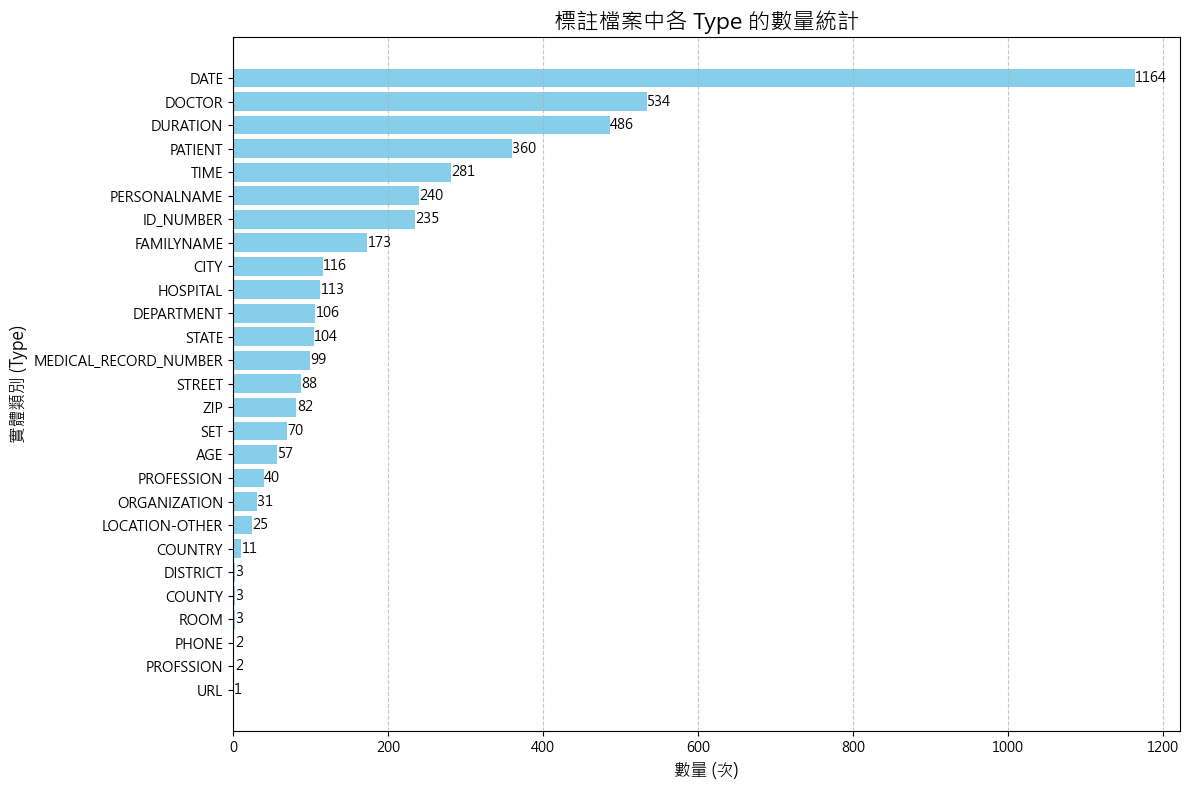

--- Cell 9: 長條圖繪製完畢 ---


In [2]:
# Cell 8: 分析標註檔案中各 Type 的數量

import os
from collections import Counter

print("--- Cell 8: 開始分析標註檔案中各 Type 的數量 ---")

# --- 1. 設定標註檔案的路徑 ---
# 您提供的標註檔案路徑
ANNOTATION_FILE_PATH_FOR_ANALYSIS = "dataset/TRAINGING_DATASET_1/Training_Dataset_01/task2_answer.txt" #<--- 使用者提供的路徑

print(f"將分析的標註檔案路徑: {ANNOTATION_FILE_PATH_FOR_ANALYSIS}")

# --- 2. 初始化計數器 ---
type_counts = Counter()
processed_lines = 0
malformed_lines = 0

# --- 3. 讀取檔案並統計 Type ---
try:
    with open(ANNOTATION_FILE_PATH_FOR_ANALYSIS, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            line = line.strip()
            if not line: # 跳過空行
                continue

            parts = line.split('\t')
            # 標註檔案格式：Filename\tType\tstart\tend\tcontent\n (共 5 個部分)
            if len(parts) == 5:
                entity_type = parts[1].strip() # Type 是第二個部分
                if entity_type: # 確保 Type 不是空字串
                    type_counts[entity_type] += 1
                    processed_lines += 1
                else:
                    print(f"警告: 第 {line_number} 行的 Type 為空，該行內容: '{line}'")
                    malformed_lines +=1
            else:
                print(f"警告: 第 {line_number} 行的格式不正確 (應有5個欄位，實際為{len(parts)}個)，該行內容: '{line}'")
                malformed_lines += 1
                
    print(f"\n成功處理 {processed_lines} 行有效的標註。")
    if malformed_lines > 0:
        print(f"發現 {malformed_lines} 行格式不正確或 Type 為空的標註。")

except FileNotFoundError:
    print(f"錯誤: 標註檔案 '{ANNOTATION_FILE_PATH_FOR_ANALYSIS}' 未找到。請檢查路徑。")
    # 如果檔案找不到，後續的打印將不會執行有意義的內容
except Exception as e:
    print(f"讀取或處理標註檔案時發生錯誤: {e}")

# --- 4. 輸出結果 ---
if type_counts:
    print("\n各 Type 的數量統計結果：")
    # 可以按數量降序排序顯示
    for entity_type, count in type_counts.most_common():
        print(f"- {entity_type}: {count} 次")
    
    total_entities = sum(type_counts.values())
    print(f"\n總計標註實體數量: {total_entities}")
    print(f"不同實體 Type 種類數量: {len(type_counts)}")
elif processed_lines == 0 and not os.path.exists(ANNOTATION_FILE_PATH_FOR_ANALYSIS):
    # 如果因為檔案不存在而 type_counts 為空，這裡不再重複打印錯誤
    pass
elif processed_lines == 0 and malformed_lines > 0 :
    print("\n沒有統計到任何有效的 Type，因為所有處理的行格式都不正確或 Type 為空。")
else:
    print("\n標註檔案中沒有找到任何有效的 Type 進行統計，或者檔案為空。")

print("\n--- Cell 8: Type 數量分析完畢 ---")

# --- 5. 使用 Matplotlib 繪製長條圖 ---
import matplotlib.pyplot as plt
import numpy as np

# 檢查 type_counts 是否有內容可以繪圖
if type_counts:
    print("\n--- Cell 9: 開始繪製 Type 數量長條圖 ---")

    # --- 5.1 設定字體以支援中文 ---
    # Matplotlib 預設字體可能不支援中文，需要指定一個系統中有的中文字體
    # 例如 'Microsoft JhengHei' (微軟正黑體) 或 'Heiti TC' (黑體-繁)
    # 如果您的系統沒有這些字體，可以換成其他的，或者需要另外安裝
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

    # --- 5.2 準備繪圖資料 ---
    # 從 type_counts 中提取資料並按數量降序排序
    sorted_counts = type_counts.most_common()
    
    # 分離出 Type 名稱和數量
    # types 會是像 ['地點', '時間', '人物'] 這樣的列表
    # counts 會是像 [150, 120, 90] 這樣的列表
    types = [item[0] for item in sorted_counts]
    counts = [item[1] for item in sorted_counts]

    # --- 5.3 繪製圖表 ---
    plt.figure(figsize=(12, 8)) # 設定圖表的尺寸，可以依據您的 Type 多寡調整
    
    # 建立長條圖
    # barh 可以建立水平長條圖，對於類別名稱較長的情況更易閱讀
    bars = plt.barh(types, counts, color='skyblue')
    
    # 在長條圖上顯示數字
    for bar in bars:
        plt.text(bar.get_width() + 0.5,  # 數字的 x 座標 (在長條右邊一點)
                 bar.get_y() + bar.get_height() / 2, # 數字的 y 座標 (在長條中間)
                 f'{int(bar.get_width())}', # 要顯示的數字
                 va='center', # 垂直對齊
                 ha='left')   # 水平對齊

    # --- 5.4 設定圖表樣式 ---
    plt.xlabel('數量 (次)', fontsize=12)         # 設定 X 軸標籤
    plt.ylabel('實體類別 (Type)', fontsize=12)    # 設定 Y 軸標籤
    plt.title('標註檔案中各 Type 的數量統計', fontsize=16) # 設定圖表標題
    plt.gca().invert_yaxis() # 將 y 軸反轉，讓數量最多的 Type 顯示在最上面
    plt.grid(axis='x', linestyle='--', alpha=0.7) # 加上格線，方便對齊觀看
    
    # --- 5.5 顯示圖表 ---
    print("長條圖建立完成，即將顯示圖表...")
    plt.tight_layout() # 自動調整圖表邊距
    plt.show()
    
    print("--- Cell 9: 長條圖繪製完畢 ---")
else:
    # 如果 type_counts 為空，則提示無法繪圖
    print("\n沒有可供繪製長條圖的數據。")

使用models/Qwen3-32B-FP8生成額外的訓練資料

採用更嚴格的兩步生成策略：

步驟一（生成獨特種子實體）：對於一個需要增強的 Type（例如 URL），如果根據 TARGET_MINIMUM_COUNT 計算出還需要 N 個新的句子，那麼我們就先讓 Qwen3-32B-FP8 為這個 Type 生成 N 個全新的、互不重複的、與現有種子也不同的「種子實體文本」（例如，如果現有種子是 "salon.com"，新生成的可能是 "healthinfo.org", "medicaljournal.net" 等不同的 URL）。

步驟二（圍繞新種子生成句子）：然後，再針對這 N 個新生成的、獨特的種子實體，每一個都生成一個包含它上下文句子（句子的風格可以參考 task1_answer.txt 中的原始文本）。
這樣就能確保每個增強出來的句子不僅上下文不同，其核心的「被標註實體」也是（新生成的）不同內容，從而極大提高數據的多樣性。這個策略非常好，但也會更消耗計算資源，因為步驟一本身就需要多次與LLM互動以確保種子的獨特性。

In [1]:
# Cell 9: 使用 Qwen 模型進行兩步式資料增強 (關閉思考模式以獲取乾淨輸出)

import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from collections import Counter, defaultdict
import uuid
import math
import re 

print("--- Cell 9: 開始使用 Qwen 進行兩步式資料增強 (關閉思考模式) ---")

# --- 1. 設定參數 ---
TRANSCRIPTIONS_SOURCE_FILE_PATH = "dataset/TRAINGING_DATASET_1/Training_Dataset_01/task1_answer.txt"
ANNOTATIONS_SOURCE_FILE_PATH = "dataset/TRAINGING_DATASET_1/Training_Dataset_01/task2_answer.txt"
MODEL_NAME_FOR_GENERATION = "E:\models\Qwen3-32B-FP8" 
DEVICE_FOR_MODEL = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_MINIMUM_COUNT = 60
CANDIDATES_TO_GENERATE_PER_LLM_CALL = 5 
MAX_TOTAL_LLM_CALLS_PER_TYPE_FOR_SEEDS = 25 

AUGMENTED_TEXT_OUTPUT_PATH = "gen_transcriptions_qwen_2step_no_think_target60.txt"
AUGMENTED_ANNOTATION_OUTPUT_PATH = "gen_annotations_qwen_2step_no_think_target60.txt"

print(f"生成模型路徑: {MODEL_NAME_FOR_GENERATION} (設備: {DEVICE_FOR_MODEL})")
# ... (其他 print 訊息)


# --- 2. 輔助函數 (load_transcriptions, load_annotations_and_get_seeds 保持不變) ---
def load_transcriptions(file_path):
    transcriptions_map = {}; print(f"\n[資料載入] 正在從 '{file_path}' 載入轉錄稿...")
    if not os.path.exists(file_path): print(f"[資料載入] 錯誤: 轉錄檔案 '{file_path}' 不存在。"); return transcriptions_map
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip();parts = line.split('\t', 1)
                if len(parts) == 2: filename_base = os.path.splitext(parts[0].strip())[0]; transcriptions_map[filename_base] = parts[1].strip()
        print(f"[資料載入] 成功載入 {len(transcriptions_map)} 筆轉錄。")
    except Exception as e: print(f"[資料載入] 讀取轉錄檔案 '{file_path}' 時發生錯誤: {e}")
    return transcriptions_map

def load_annotations_and_get_seeds(annotation_file_path):
    type_counts = Counter(); seeds_by_type = defaultdict(set); annotations_by_file = defaultdict(list)
    print(f"\n[資料載入] 正在從 '{annotation_file_path}' 載入標註並提取種子...")
    if not os.path.exists(annotation_file_path): print(f"[資料載入] 錯誤: 標註檔案 '{annotation_file_path}' 不存在。"); return type_counts, seeds_by_type, annotations_by_file
    try:
        with open(annotation_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip();parts = line.split('\t')
                if len(parts) == 5:
                    fn_base, et, s, e, ec = os.path.splitext(parts[0].strip())[0], parts[1].strip(), parts[2], parts[3], parts[4].strip()
                    if et and ec:
                        type_counts[et] += 1; seeds_by_type[et].add(ec)
                        annotations_by_file[fn_base].append({"type": et, "text": ec, "start": float(s), "end": float(e)})
        s_list = {k: sorted(list(v)) for k, v in seeds_by_type.items()}
        print(f"[資料載入] 成功載入標註：總共 {sum(type_counts.values())} 個實體，{len(type_counts)} 個 Type。為 {len(s_list)} 個 Type 提取了種子。")
        return type_counts, s_list, annotations_by_file
    except Exception as e: print(f"[資料載入] 讀取或處理標註檔案 '{annotation_file_path}' 時發生錯誤: {e}"); return Counter(), defaultdict(list), defaultdict(list)

# --- 3. 載入 Qwen LLM 模型和分詞器 (保持不變) ---
llm_tokenizer = None
llm_model = None
if DEVICE_FOR_MODEL == "cuda" and not torch.cuda.is_available(): DEVICE_FOR_MODEL = "cpu"; print("警告: CUDA 不可用...")
try:
    print(f"\n正在從本地路徑載入 Qwen Tokenizer: {MODEL_NAME_FOR_GENERATION}...")
    llm_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_FOR_GENERATION, trust_remote_code=True)
    print(f"正在從本地路徑以量化模式載入 Qwen Model: {MODEL_NAME_FOR_GENERATION}...")
    model_dtype_config = torch.bfloat16 if DEVICE_FOR_MODEL == "cuda" else torch.float32
    quant_config = BitsAndBytesConfig(load_in_8bit=True) if DEVICE_FOR_MODEL == "cuda" else None
    if DEVICE_FOR_MODEL == "cuda": print("提示：將使用 8-bit 量化 (BitsAndBytesConfig)。")
    
    llm_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME_FOR_GENERATION, quantization_config=quant_config, torch_dtype=model_dtype_config,
        device_map="auto", trust_remote_code=True, attn_implementation="sdpa"
    )
    if llm_tokenizer.pad_token_id is None: llm_tokenizer.pad_token_id = llm_tokenizer.eos_token_id
    print(f"{MODEL_NAME_FOR_GENERATION} 模型和分詞器從本地載入成功。")
except Exception as e: print(f"從本地路徑 '{MODEL_NAME_FOR_GENERATION}' 載入模型或分詞器失敗: {e}")


# --- 4. 資料增強主邏輯 ---
def generate_n_unique_variant_seeds_qwen_no_think( # 更新函數名
    entity_type, 
    existing_seeds_for_type_set, 
    num_unique_to_generate, 
    llm_model, 
    llm_tokenizer
):
    if not llm_model or not llm_tokenizer: return []
    
    newly_generated_unique_seeds = []
    known_seeds_for_this_type_in_session = set(s.lower() for s in existing_seeds_for_type_set) 
    inspiration_seeds_list = list(existing_seeds_for_type_set)
    if not inspiration_seeds_list: inspiration_seeds_list.append(f"a plausible medical {entity_type.lower()}")

    print(f"    [種子生成階段] 為 Type '{entity_type}' 目標生成 {num_unique_to_generate} 個新獨特種子 (思考模式關閉)...")
    llm_calls_count = 0
    while len(newly_generated_unique_seeds) < num_unique_to_generate and llm_calls_count < MAX_TOTAL_LLM_CALLS_PER_TYPE_FOR_SEEDS:
        llm_calls_count += 1
        current_inspiration_seed = inspiration_seeds_list[llm_calls_count % len(inspiration_seeds_list)]
        
        few_shot_output_example = ""
        if entity_type == "URL": few_shot_output_example = "Example of desired output if I ask for 3 new URLs (each on a new line):\nmedinfo.com\npatienthealthportal.org\nresearchstudy.edu"
        elif entity_type == "AGE": few_shot_output_example = "Example of desired output if I ask for 2 new AGEs (each on a new line):\n52 years old\nseventy-three"

        system_prompt_seeds = "You are an extremely precise data generation assistant. Your ONLY task is to provide new, distinct entity instances of a specified type. You MUST strictly follow the output format: list each new instance on a new line. NO explanations, NO numbering, NO conversation, NO meta-comments."
        user_prompt_seeds = (
            f"The target entity type is: '{entity_type}'.\n"
            f"For style/format reference only, an existing example of this type is: '{current_inspiration_seed}'.\n"
            f"Please generate {CANDIDATES_TO_GENERATE_PER_LLM_CALL} new, distinct, and realistic entity instances that are also of type '{entity_type}'. "
            f"Each new instance MUST be different in content from known examples and from each other. They should be plausible in a medical context.\n"
            f"{few_shot_output_example}\n"
            f"Provide ONLY the {CANDIDATES_TO_GENERATE_PER_LLM_CALL} new instances, each on its own new line. Nothing else."
        )
        messages_for_seeds = [{"role": "system", "content": system_prompt_seeds}, {"role": "user", "content": user_prompt_seeds}]
        print(f"      [種子生成] LLM Call #{llm_calls_count} (已生成 {len(newly_generated_unique_seeds)}/{num_unique_to_generate}) (靈感: '{current_inspiration_seed}')...")

        try:
            model_inputs = llm_tokenizer.apply_chat_template(
                messages_for_seeds, return_tensors="pt", 
                add_generation_prompt=True, 
                enable_thinking=False  # **** 關鍵更改：關閉思考模式 ****
            ).to(llm_model.device)
            input_ids_length = model_inputs.shape[1]
            
            generated_ids = llm_model.generate(
                model_inputs, max_new_tokens=70 * CANDIDATES_TO_GENERATE_PER_LLM_CALL, 
                temperature=0.7, # 可以從稍低的 temperature 開始測試 (因思考模式關閉)
                do_sample=True, top_p=0.9, repetition_penalty=1.15,
                eos_token_id=llm_tokenizer.eos_token_id, pad_token_id=llm_tokenizer.pad_token_id 
            )
            newly_generated_ids = generated_ids[0][input_ids_length:]
            decoded_batch_text = llm_tokenizer.decode(newly_generated_ids, skip_special_tokens=True).strip()
            
            # 簡化解析邏輯，因為預期沒有 <think> 塊
            candidate_seeds_from_this_batch = [s.strip("\"' ") for s in decoded_batch_text.split('\n') if s.strip()]
            batch_added_count = 0

            for raw_candidate_text in candidate_seeds_from_this_batch:
                candidate_text = raw_candidate_text # 初始值
                print(f"        [種子生成] LLM原始候選 (思考關閉): '{candidate_text}'")
                
                # 仍然可以做一些基本清理，例如移除可能的編號或前後引號
                candidate_text = re.sub(r"^\s*(\d+[.)]|\*|-)\s*", "", candidate_text).strip()
                candidate_text = candidate_text.strip("\"' ")

                print(f"        [種子生成] 清理後候選: '{candidate_text}'")
                
                is_valid_seed = False
                if not candidate_text or not (1 < len(candidate_text) < 100):
                    print(f"        [種子生成] 候選 '{candidate_text}' 長度無效。"); continue

                # 特定類型驗證 (與上一版相同，可以繼續擴展)
                if entity_type == "URL":
                    if "." in candidate_text and " " not in candidate_text and not any(kw in candidate_text.lower() for kw in ["example", "explanation", "sentence", "instance", "includes", "note:", "<", ">"]) and len(candidate_text.split('.')) >= 2 and len(candidate_text.split('.')[-1]) >=2 :
                        is_valid_seed = True
                    else: print(f"        [種子生成] URL候選 '{candidate_text}' 未通過URL格式檢查。")
                elif entity_type == "AGE":
                    if any(char.isdigit() for char in candidate_text) and not any(kw in candidate_text.lower() for kw in ["example", "explanation", "sentence", "instance", "includes", "note:", "<", ">"]):
                        is_valid_seed = True
                    else: print(f"        [種子生成] AGE候選 '{candidate_text}' 未通過AGE格式檢查。")
                else: 
                    if not any(kw in candidate_text.lower() for kw in ["example", "explanation", "sentence", "instance", "includes", "note:", "<", ">"]):
                        is_valid_seed = True
                    else: print(f"        [種子生成] '{entity_type}' 候選 '{candidate_text}' 含禁用詞。")
                
                if is_valid_seed and (candidate_text.lower() not in known_seeds_for_this_type_in_session):
                    newly_generated_unique_seeds.append(candidate_text)
                    known_seeds_for_this_type_in_session.add(candidate_text.lower())
                    batch_added_count += 1
                    print(f"          [種子生成] 成功添加新獨特種子: '{candidate_text}' (當前總計 {len(newly_generated_unique_seeds)}/{num_unique_to_generate})")
                    if len(newly_generated_unique_seeds) >= num_unique_to_generate: break 
                elif is_valid_seed and (candidate_text.lower() in known_seeds_for_this_type_in_session):
                    print(f"        [種子生成] 候選 '{candidate_text}' 與已知種子重複。")
            
            if len(newly_generated_unique_seeds) >= num_unique_to_generate: break 
            if batch_added_count == 0: print(f"        [種子生成]警告: LLM Call #{llm_calls_count} 未能生成任何【新的且有效的】獨特種子。輸出: '{decoded_batch_text[:150]}...'")
        except Exception as sg_exc: print(f"      [種子生成] LLM Call #{llm_calls_count} 發生錯誤: {sg_exc}")
    
    if len(newly_generated_unique_seeds) < num_unique_to_generate: print(f"    [種子生成階段完成] 警告: Type '{entity_type}' 目標 {num_unique_to_generate}，實際獲得 {len(newly_generated_unique_seeds)}。")
    else: print(f"    [種子生成階段完成] Type '{entity_type}' 成功獲得 {len(newly_generated_unique_seeds)} 個新獨特種子。")
    return newly_generated_unique_seeds


def augment_data_final_strategy_qwen_no_think( # 更新函數名
    transcriptions_map, annotations_by_file, type_counts_original, 
    original_seed_entities_by_type, llm_model, llm_tokenizer
):
    if not llm_model or not llm_tokenizer: print("模型或Tokenizer未初始化。"); return
    if not all([transcriptions_map, annotations_by_file, type_counts_original, original_seed_entities_by_type]):
        print("輸入資料不完整。"); return
        
    print("\n開始最終策略資料增強 (Qwen無思考模式，批次生成獨特種子 -> 生成句子)...")
    prompt_instruction_templates_for_sentence = [ 
        # ... (與上一版本相同的句子模板) ...
        "Generate a sentence where a doctor might explain a finding to a patient, including the '{entity_type}' '{entity_text}'.",
        "Create a sentence from a patient's medical history note that includes the '{entity_type}' '{entity_text}'.",
        "Imagine a nurse is documenting a patient interaction; generate a sentence they might write that includes the '{entity_type}' '{entity_text}'.",
        "Generate a sentence about medical appointment scheduling or referral that involves the '{entity_type}' '{entity_text}'.",
        "Craft a sentence about medical billing or insurance that mentions the '{entity_type}' '{entity_text}'."
    ]
    with open(AUGMENTED_TEXT_OUTPUT_PATH, 'w', encoding='utf-8') as f_text, \
         open(AUGMENTED_ANNOTATION_OUTPUT_PATH, 'w', encoding='utf-8') as f_ann:
        total_generated_sentences_overall = 0
        for entity_type, original_count in sorted(type_counts_original.items(), key=lambda item: item[1]):
            if original_count < TARGET_MINIMUM_COUNT and original_count > 0:
                num_sentences_to_add_for_type = TARGET_MINIMUM_COUNT - original_count
                print(f"\nType '{entity_type}': 原始計數 {original_count}，目標新增 {num_sentences_to_add_for_type} 條句子。")
                
                current_original_seeds_set = set(original_seed_entities_by_type.get(entity_type, []))
                if not current_original_seeds_set: print(f"  警告: Type '{entity_type}' 無原始種子。跳過。"); continue

                newly_generated_seeds_for_sentences = generate_n_unique_variant_seeds_qwen_no_think( # 調用新版種子生成
                    entity_type, current_original_seeds_set, 
                    num_sentences_to_add_for_type, 
                    llm_model, llm_tokenizer
                )
                
                final_seeds_for_sentence_gen = newly_generated_seeds_for_sentences
                if not final_seeds_for_sentence_gen:
                    print(f"  警告: 未能為 Type '{entity_type}' 生成任何新的獨特種子。將使用原始種子列表。")
                    final_seeds_for_sentence_gen = list(current_original_seeds_set) 
                    if not final_seeds_for_sentence_gen: print(f"    Type '{entity_type}' 原始種子也為空。"); continue
                
                print(f"  [句子生成階段] 將使用 {len(final_seeds_for_sentence_gen)} 個種子為 '{entity_type}' 生成 {num_sentences_to_add_for_type} 個句子。")
                source_contexts_for_type = [transcriptions_map[fn_base] for fn_base, ann_list in annotations_by_file.items() if fn_base in transcriptions_map for ann_item in ann_list if ann_item["type"] == entity_type]
                if not source_contexts_for_type: source_contexts_for_type.append("A patient is discussing symptoms with a doctor.") 
                
                num_available_contexts = len(source_contexts_for_type)
                generated_sentences_for_this_type_count = 0

                for i in range(num_sentences_to_add_for_type):
                    if not final_seeds_for_sentence_gen : break 
                    current_final_seed_text = final_seeds_for_sentence_gen[i % len(final_seeds_for_sentence_gen)]
                    inspirational_context_sentence = source_contexts_for_type[i % num_available_contexts]
                    current_instruction_template = prompt_instruction_templates_for_sentence[i % len(prompt_instruction_templates_for_sentence)]
                    specific_sentence_instruction = current_instruction_template.format(entity_text=current_final_seed_text, entity_type=entity_type)
                    
                    print(f"    為 '{entity_type}' (句子 {generated_sentences_for_this_type_count + 1}/{num_sentences_to_add_for_type}) 用種子 '{current_final_seed_text}' 生成...")
                    
                    system_prompt_sentence = "You are a very precise medical assistant. Your task is to generate a single, new, short, and realistic sentence for medical NER training data. This new sentence MUST be inspired by the style of an example sentence provided but be DIFFERENT in content. It must be relevant to a medical context. Respond ONLY with the generated sentence itself."
                    user_prompt_sentence = (
                        f"For stylistic inspiration, an example sentence is: \"{inspirational_context_sentence[:800]}\".\n"
                        f"The key entity of type '{entity_type}' that MUST be included in your new sentence is: '{current_final_seed_text}'.\n"
                        f"Your specific task for this sentence is: {specific_sentence_instruction}\n"
                        f"Ensure the language of your generated sentence precisely matches the language of the entity ('{current_final_seed_text}')."
                    )
                    messages_step2 = [{"role": "system", "content": system_prompt_sentence}, {"role": "user", "content": user_prompt_sentence}]

                    try:
                        model_inputs_step2 = llm_tokenizer.apply_chat_template(
                            messages_step2, return_tensors="pt", 
                            add_generation_prompt=True,
                            enable_thinking=False # **** 關閉思考模式 ****
                        ).to(llm_model.device)
                        input_ids_length_step2 = model_inputs_step2.shape[1]
                        generated_ids_step2 = llm_model.generate(
                            model_inputs_step2, max_new_tokens=120, 
                            temperature=0.8, # 句子生成時可以保持稍高一點的temperature
                            do_sample=True, top_p=0.95,
                            num_beams=1, eos_token_id=llm_tokenizer.eos_token_id, pad_token_id=llm_tokenizer.pad_token_id
                        )
                        newly_generated_ids_step2 = generated_ids_step2[0][input_ids_length_step2:]
                        generated_sentence = llm_tokenizer.decode(newly_generated_ids_step2, skip_special_tokens=True).strip()
                        generated_sentence = generated_sentence.strip("\"'") # 基本清理
                        
                        if not generated_sentence: print(f"      警告: 為 '{current_final_seed_text}' 生成了空句子。"); continue
                        if not re.search(r'\b' + re.escape(current_final_seed_text.lower()) + r'\b', generated_sentence.lower(), flags=re.IGNORECASE):
                            print(f"      警告: 種子 '{current_final_seed_text}' 未在句 '{generated_sentence}' 中找到。跳過。"); continue

                        gen_filename = f"gen_{entity_type.lower()}_{str(uuid.uuid4())[:8]}"
                        f_text.write(f"{gen_filename}\t{generated_sentence}\n")
                        f_ann.write(f"{gen_filename}\t{entity_type}\tNone\tNone\t{current_final_seed_text}\n")
                        generated_sentences_for_this_type_count += 1
                        total_generated_sentences_overall += 1
                        print(f"      成功 ({generated_sentences_for_this_type_count}/{num_sentences_to_add_for_type}): {gen_filename} -> '{generated_sentence[:80]}...'")
                    except Exception as gen_exc_step2:
                        print(f"      為種子 '{current_final_seed_text}' 生成句子時發生錯誤: {gen_exc_step2}")
                        if "out of memory" in str(gen_exc_step2).lower(): print("        CUDA out of memory 錯誤。")
            elif original_count > 0:
                print(f"Type '{entity_type}': 原始計數 {original_count}，已達標，無需增強。")
    print(f"\n兩步式資料增強完成。總共新生成了 {total_generated_sentences_overall} 個句子。")
    print(f"增強文本已儲存到: {AUGMENTED_TEXT_OUTPUT_PATH}")
    print(f"增強標註已儲存到: {AUGMENTED_ANNOTATION_OUTPUT_PATH}")

# --- 5. 執行主要邏輯 ---
transcriptions = load_transcriptions(TRANSCRIPTIONS_SOURCE_FILE_PATH)
original_counts, original_seeds_dict, annotations_by_filename = load_annotations_and_get_seeds(ANNOTATIONS_SOURCE_FILE_PATH)

if llm_model and llm_tokenizer and transcriptions and original_counts and original_seeds_dict and annotations_by_filename:
    augment_data_final_strategy_qwen_no_think( # 更新函數名
        transcriptions, annotations_by_filename, 
        original_counts, original_seeds_dict,
        llm_model, llm_tokenizer
    )
else:
    print("由於必要元件未能成功載入/提取，資料增強步驟將被跳過。")

print(f"\n--- Cell 9: Qwen ({MODEL_NAME_FOR_GENERATION}) 兩步式資料增強 (無思考模式) 完畢 (或跳過) ---")

c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Cell 9: 開始使用 Qwen 進行兩步式資料增強 (關閉思考模式) ---
生成模型路徑: E:\models\Qwen3-32B-FP8 (設備: cuda)

正在從本地路徑載入 Qwen Tokenizer: E:\models\Qwen3-32B-FP8...
正在從本地路徑以量化模式載入 Qwen Model: E:\models\Qwen3-32B-FP8...
提示：將使用 8-bit 量化 (BitsAndBytesConfig)。


c:\Users\ISLAB-121\.conda\envs\aicup\lib\site-packages\transformers\quantizers\auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Loading checkpoint shards: 100%|██████████| 7/7 [01:29<00:00, 12.83s/it]


E:\models\Qwen3-32B-FP8 模型和分詞器從本地載入成功。

[資料載入] 正在從 'dataset/TRAINGING_DATASET_1/Training_Dataset_01/task1_answer.txt' 載入轉錄稿...
[資料載入] 成功載入 2314 筆轉錄。

[資料載入] 正在從 'dataset/TRAINGING_DATASET_1/Training_Dataset_01/task2_answer.txt' 載入標註並提取種子...
[資料載入] 成功載入標註：總共 4429 個實體，27 個 Type。為 27 個 Type 提取了種子。

開始最終策略資料增強 (Qwen無思考模式，批次生成獨特種子 -> 生成句子)...

Type 'URL': 原始計數 1，目標新增 59 條句子。
    [種子生成階段] 為 Type 'URL' 目標生成 59 個新獨特種子 (思考模式關閉)...
      [種子生成] LLM Call #1 (已生成 0/59) (靈感: 'salon.com')...
        [種子生成] LLM原始候選 (思考關閉): 'clinicaltrialsmonitor.net'
        [種子生成] 清理後候選: 'clinicaltrialsmonitor.net'
          [種子生成] 成功添加新獨特種子: 'clinicaltrialsmonitor.net' (當前總計 1/59)
        [種子生成] LLM原始候選 (思考關閉): 'doctorline.co.uk'
        [種子生成] 清理後候選: 'doctorline.co.uk'
          [種子生成] 成功添加新獨特種子: 'doctorline.co.uk' (當前總計 2/59)
        [種子生成] LLM原始候選 (思考關閉): 'healthevidencejournal.org'
        [種子生成] 清理後候選: 'healthevidencejournal.org'
          [種子生成] 成功添加新獨特種子: 'healthevidencejournal.org' (當前總計 3/59)
        [種子生成